![LoanMat](image/LoanMat.png)

# Introduction

Dans le milieu bancaire, évaluer les demandes de prêt est essentiel pour gérer les risques de crédit et assurer la rentabilité de l'institution. Prédire la capacité d'un client à rembourser son prêt est une tâche capitale, mais souvent ardue et fastidieuse, généralement réalisée sous supervision humaine. Cette approche peut entraîner des variations dans les décisions en fonction de chaque agent, créant ainsi des écarts de traitement entre les clients. 

Ce projet vise à développer un modèle d’apprentissage automatique capable de prédire l’éligibilité à un prêt en se basant sur des critères financiers et démographiques tels que les revenus, les antécédents de crédit et d’autres informations. Ce modèle pourrait également servir de support aux agents bancaires en automatisant une partie du processus décisionnel, similaire aux systèmes de suivi des candidatures (ATS) utilisés dans le recrutement, permettant ainsi un pré-tri des demandes plus rapide, cohérent et objectif.

Nous commencerons par importer les données, gérer les valeurs manquantes, les standardiser.

On testera plusieurs modèles de classification(Ceux qu'on a vu en cours) pour évaluer leurs performances et déterminer le plus précis basée sur plusieurs metriques différentes pour enfin utiliser le meilleur modèle pour prédire l’éligibilité aux prêts sur le dataset de test.

On commence par importer les bibliothèques essentielles pour notre projet :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

Pour mener à bien ce projet, nous utiliserons un jeu de données provenant de Kaggle : [Loan Eligible Dataset de Vikas Ukani](https://www.kaggle.com/datasets/vikasukani/loan-eligible-dataset). 
Ce jeu de données se compose de deux fichiers distincts : un jeu d’entraînement (loan-train.csv) et un jeu de test (loan-test.csv).

Ce jeu de donnée repertorie les demandes de prêt et leur statut d'acceptation. Ainsi notre modèle sera entrainé sur les décisions humaines déjà prise et peut donc être sujets aux biais (exemple biais discriminatoire même si dans notre cas aucune donnée ethnique n'est consignée).

In [2]:
train_data=pd.read_csv("loan-train.csv")
test_data=pd.read_csv("loan-test.csv")

<div style="font-weight: bold; background: rgba(255,219,187,0.2); border: 2px solid #ffa500; border-left-width: 10px; padding: 1.5rem 2rem;box-sizing: border-box; border-radius: 10px;">
Ce jeu de donnée repertorie les demandes de prêt et leur statut d'acceptation.<br/>Notre modèle sera donc entrainé sur des décisions humaines déjà prise et peut donc être sujets aux biais (exemple biais discriminatoire même si dans notre cas aucune donnée ethnique n'est consignée).
</div>

## Familiarisation avec le Dataset

In [4]:
display(train_data.head())

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

In [5]:
display(test_data.head())

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001015   Male     Yes          0      Graduate            No   
1  LP001022   Male     Yes          1      Graduate            No   
2  LP001031   Male     Yes          2      Graduate            No   
3  LP001035   Male     Yes          2      Graduate            No   
4  LP001051   Male      No          0  Not Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5720                  0       110.0             360.0   
1             3076               1500       126.0             360.0   
2             5000               1800       208.0             360.0   
3             2340               2546       100.0             360.0   
4             3276                  0        78.0             360.0   

   Credit_History Property_Area  
0             1.0         Urban  
1             1.0         Urban  
2             1.0         Urban  
3             NaN         Urban  
4             1.0         Urban

- `Loan ID` : Identifiant unique pour chaque demande de prêt.

- `Gender` : Genre de l'emprunteur (Male/Female).

- `Married` : Statut marital de l'emprunteur (Yes/No).

- `Dependents` : Nombre de personnes à charge (0, 1, 2, ou 3+).

- `Education` : Niveau d'éducation de l'emprunteur (Graduate/Not Graduate).

- `Self Employed` : Statut de travail indépendant (Yes/No).

- `ApplicantIncome` : Revenu mensuel de l'emprunteur.

- `CoapplicantIncome` : Revenu mensuel du co-emprunteur.

- `LoanAmount` : Montant du prêt demand' (en milliers).

- `Loan Amount Term` : Durée du prêt en mois.

- `Credit History` : Historique de crédit (1 pour une bonne historique, 0 pour un historique mauvais).

- `Property Area` : Zone de résidence de l’emprunteur (Urban, Semiurban, Rural).

- `Loan Status` : Statut de l'acceptation du prêt (Y pour accepté, N pour refusé [uniquement disponible dans le jeu d’entraînement]).

In [4]:
train_data.shape

(614, 13)

In [5]:
test_data.shape

(367, 12)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            367 non-null    object 
 1   Gender             356 non-null    object 
 2   Married            367 non-null    object 
 3   Dependents         357 non-null    object 
 4   Education          367 non-null    object 
 5   Self_Employed      344 non-null    object 
 6   ApplicantIncome    367 non-null    int64  
 7   CoapplicantIncome  367 non-null    int64  
 8   LoanAmount         362 non-null    float64
 9   Loan_Amount_Term   361 non-null    float64
 10  Credit_History     338 non-null    float64
 11  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 34.5+ KB


In [9]:
train_data.describe()

ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000

- `count` = Représentre le nombre de valeurs non nulles.

- `mean` = Représente la moyenne

- `std` (Standard deviation) = Une mesure de la dispersion des valeurs autour de la moyenne. Une déviation standard plus élevée indique une plus grande variabilité des données.

- `min` = La plus petite valeur.

- `25%` = Représente la valeur en dessous de laquelle se trouvent 25 % des données (premier quartile).

- `50%` = Représente la valeur en dessous de laquelle se trouvent 50 % des données (médiane ou deuxième quartile).

- `75%` = Représente la valeur en dessous de laquelle se trouvent 75 % des données (troisième quartile).

- `max` = La plus grande valeur.

In [10]:
import plotly.graph_objects as go

# Afficher le graphique
loan_status_counts = train_data['Loan_Status'].value_counts().reset_index()
loan_status_counts.columns = ['Loan_Status', 'count']

fig = go.Figure()

fig.add_trace(go.Bar(
    x=loan_status_counts['Loan_Status'],
    y=loan_status_counts['count'],
    text=loan_status_counts['count'],
    textposition='auto',
    marker=dict(color=['#636EFA', '#636EFA'])
))
fig.update_layout(
    title="Nombre de prêts acceptés et refusés",
    xaxis_title="Statut du Prêt (Loan_Status)",
    yaxis_title="Nombre",
    showlegend=False
)

fig.show()
ratio = loan_status_counts.loc[loan_status_counts['Loan_Status'] == 'Y', 'count'].values[0] / loan_status_counts['count'].sum()
print(f"Pourcentage de prêts accepté : {ratio:.2%}")

Pourcentage de prêts accepté : 69.54%


On voit qu'on à a peu près 7 prêts sur 10 qui sont accepté ce qui pourrait représenter un biais, dans ce cas peut être que les emprunteurs de cette banque sont qualifiés et fiable ce qui ne représenterai pas de manière objectif l'éligibilité d'un accès à un prêt

In [11]:
#On rentre le nom des colonnes qu'on vas afficher
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
#On crée un subplot pour chaque colonne
fig = make_subplots(rows=2, cols=3, subplot_titles=categorical_features)
for i, feature in enumerate(categorical_features):
    counts = train_data[feature].value_counts().reset_index()
    counts.columns = [feature, 'count']
    fig.add_trace(px.bar(counts, x=feature, y='count').data[0], row=(i // 3) + 1, col=(i % 3) + 1)

fig.update_layout(title='Diagramme en baton de la répartition des colonnes catégorielles', showlegend=False)
fig.show()

On observe :
- une majorité d'hommes (5 fois plus que de femmes)
- il y a plus de demandeur mariés que non mariés (1,5 fois plus que de non marié)
- environ 3/5ème des demandeur n'ont pas d'autres personnes à charge pour leur prêt
-  5 demandeurs sur 6 sont diplomés
-  la plupart (5/6) ne sont pas auto entrepreneur/ indépendant
-  la distribution des demandeurs de prêt en fonction de leur lieu de résidence est assez homogène.

In [12]:
# Filtrer les données pour hommes et femmes
loan_status_gender_counts = train_data.groupby(['Gender', 'Loan_Status']).size().unstack().reset_index()
loan_status_gender_counts.columns = ['Gender', 'Refused', 'Accepted']

# Ajouter une trace pour hommes et une pour femmes
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['Accepted', 'Refused'],
    y=loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Male', ['Accepted', 'Refused']].values.flatten(),
    text=loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Male', ['Accepted', 'Refused']].values.flatten(),
    textposition='auto',
    name='Male',
    marker=dict(color='#636EFA')
))

fig.add_trace(go.Bar(
    x=['Accepted', 'Refused'],
    y=loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Female', ['Accepted', 'Refused']].values.flatten(),
    text=loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Female', ['Accepted', 'Refused']].values.flatten(),
    textposition='auto',
    name='Female',
    marker=dict(color='#EF553B')
))

# Mise à jour de la mise en page
fig.update_layout(
    title="Comparaison des prêts acceptés et refusés par genre",
    xaxis_title="Statut du Prêt (Loan_Status)",
    yaxis_title="Nombre",
    barmode='group',
    showlegend=True
)

# Afficher le graphique
fig.show()
# Calcul du ratio des prêts acceptés pour les hommes
male_accepted = loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Male', 'Accepted'].values[0]
male_total = loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Male', ['Accepted', 'Refused']].sum(axis=1).values[0]
male_ratio = male_accepted / male_total

# Calcul du ratio des prêts acceptés pour les femmes
female_accepted = loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Female', 'Accepted'].values[0]
female_total = loan_status_gender_counts.loc[loan_status_gender_counts['Gender'] == 'Female', ['Accepted', 'Refused']].sum(axis=1).values[0]
female_ratio = female_accepted / female_total

# Afficher les résultats
print(f"Ratio des prêts acceptés pour les hommes : {male_ratio:.2%}")
print(f"Ratio des prêts acceptés pour les femmes : {female_ratio:.2%}")

Ratio des prêts acceptés pour les hommes : 69.94%
Ratio des prêts acceptés pour les femmes : 68.75%


**A première vu on a pas de biais de genre (seulement 2,6% d'écart)**

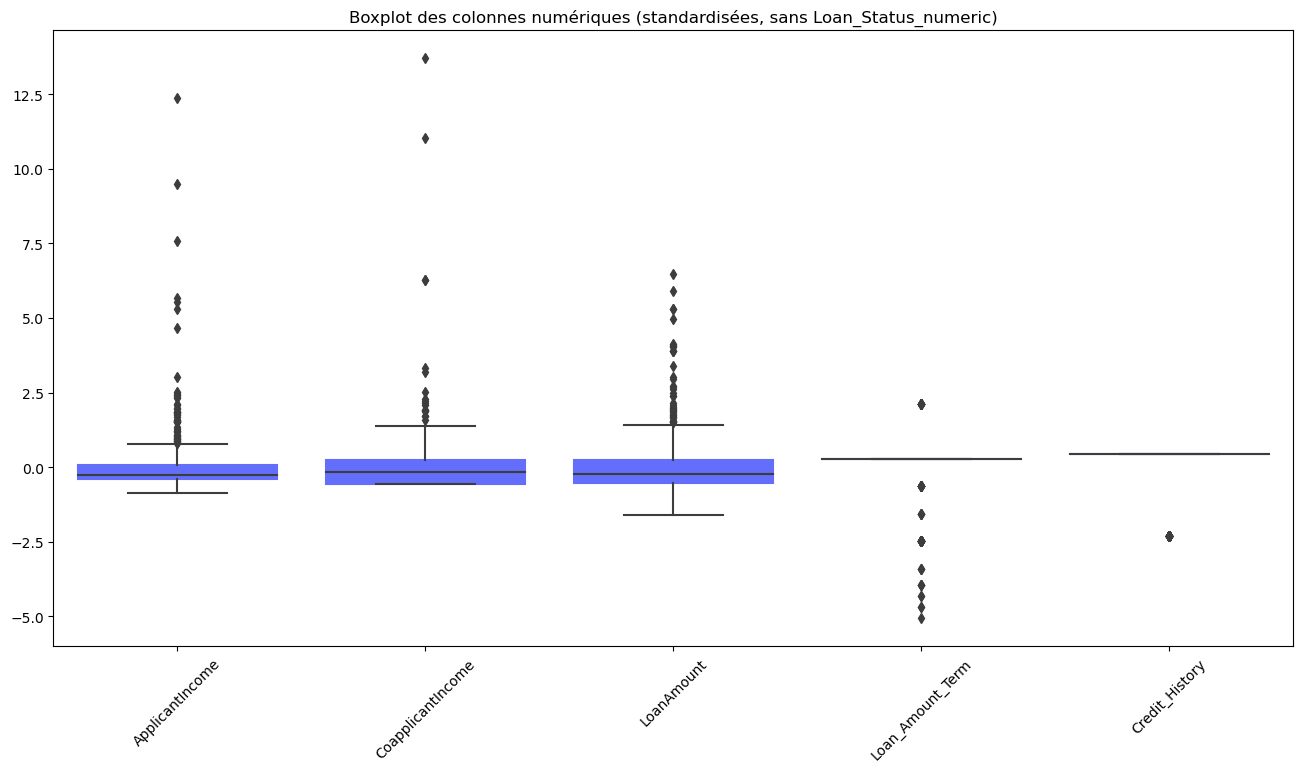

In [13]:
#On standardise les données seulement numérique
numeric_cols = train_data.select_dtypes(include=[float, int])

#On supprime la colonne Lona_Status_numeric
numeric_cols = numeric_cols.drop(columns=['Loan_Status_numeric'], errors='ignore')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)

#On convertie les données en DataFrame pour pouvoir avoir le graphique
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols.drop(columns=['Loan_Status_numeric'], errors='ignore').columns)
#Tracer un boxplot standardisé
plt.figure(figsize=(16, 8))
sns.boxplot(data=scaled_df, boxprops=dict(color='#636EFA'))
plt.title("Boxplot des colonnes numériques (standardisées, sans Loan_Status_numeric)")
plt.xticks(rotation=45)
plt.show()

Ce graphique à pour but de montrer les Outliers parmis les colonnes, ce sont les valeurs qui sortent de la médianes (la sorte de boite à moustache).
On peut observer des Outliers mais dans ce cas ça n'est pas vraiment choquant parce que le data set est petit 600 lignes donc des valeurs qui pourraient paraitre démesuré par rapport à la moyenne sont normales.

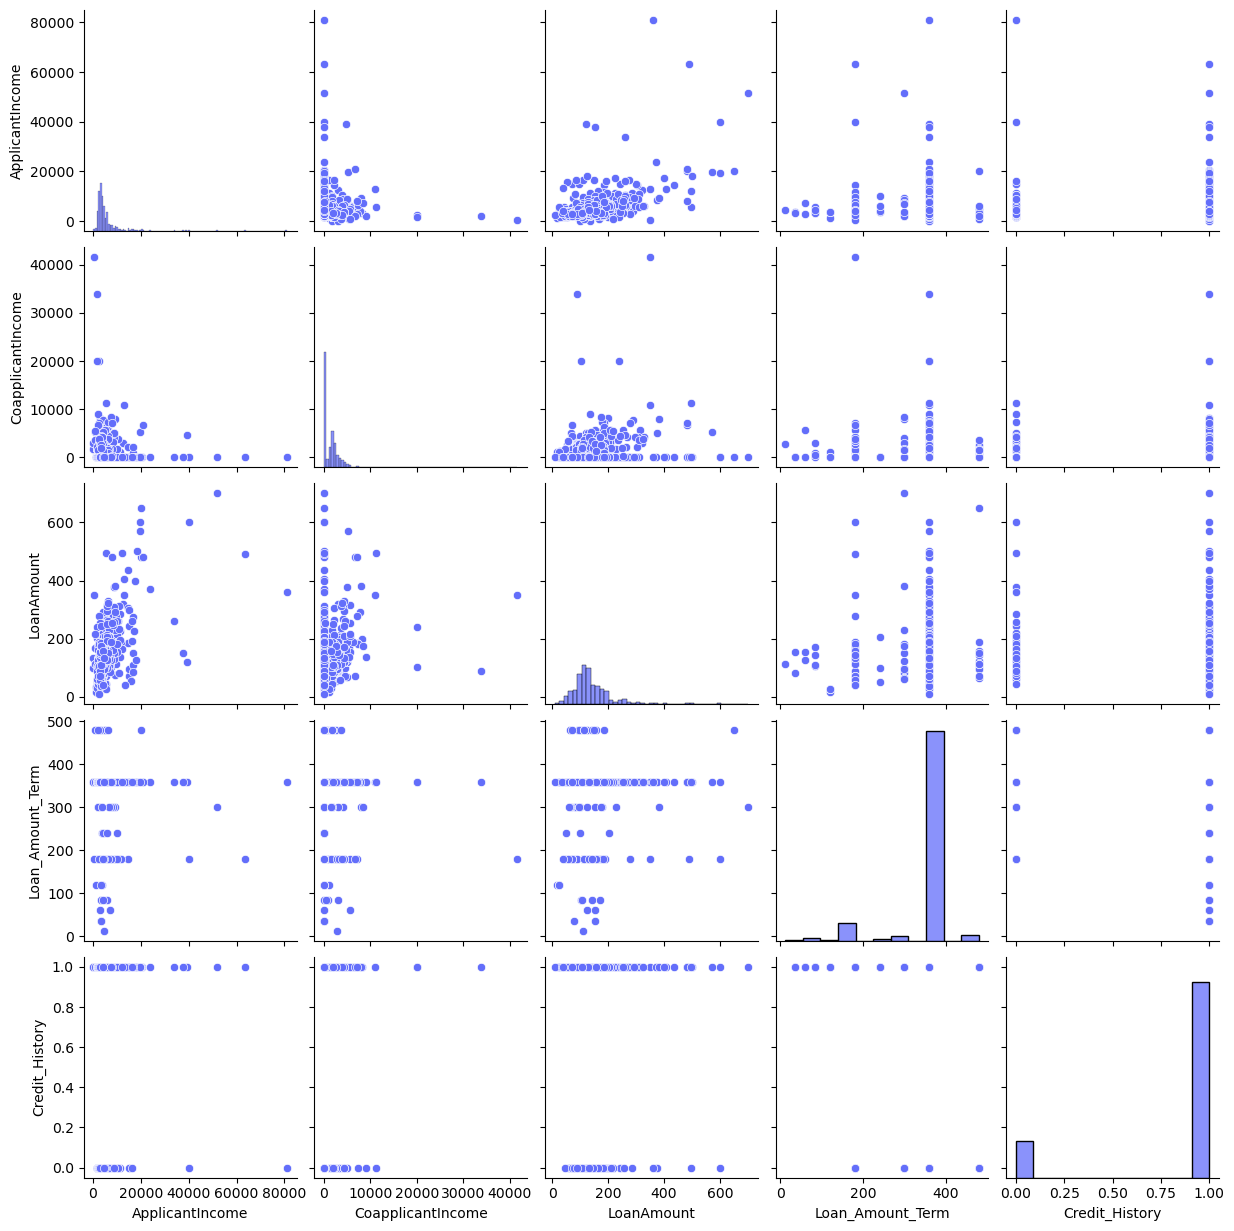

In [14]:
sns.pairplot(train_data.select_dtypes(["int","float"]), diag_kws={'color': '#636EFA'}, plot_kws={'color': '#636EFA'})

- On voit quand même que `AppliantIncome` et `CoApplicantIncome` ont des répartitions assez asymétriques avec quand même quelques Outliers on peut en déduire que les personnes qui demandent un prêt dans cette banque ont une répartition salariale assez varié ou que certaines données sont aberrantes

Mais la répartition montre à croire que la plupart des `AppliantIncome` et `CoApplicantIncome` on un revenu modeste de moins de `10 000` <- valeur standardisé

- Pour `LoanAmount` on voit que majorité des montants des emprunts sont entre `100` et `200` <- valeur standardisé

- Pour `Credit_History` on voit qu'une majeur partie des demandeurs ont une bon historique de prêt

On peut voir quand même quelques **Outliers**

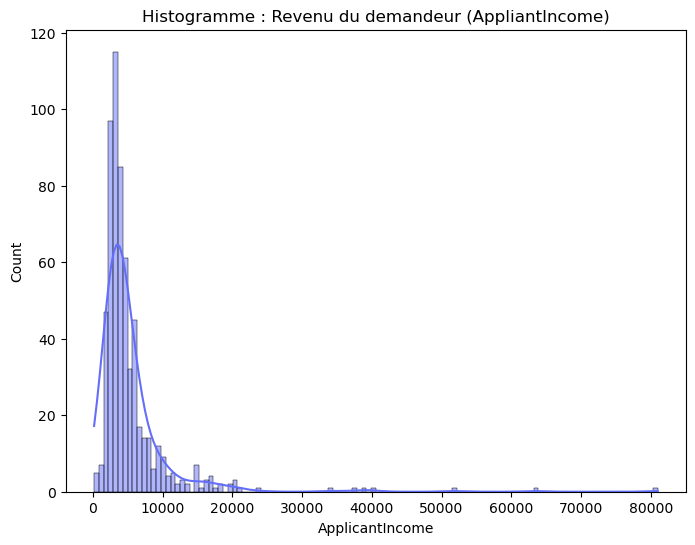

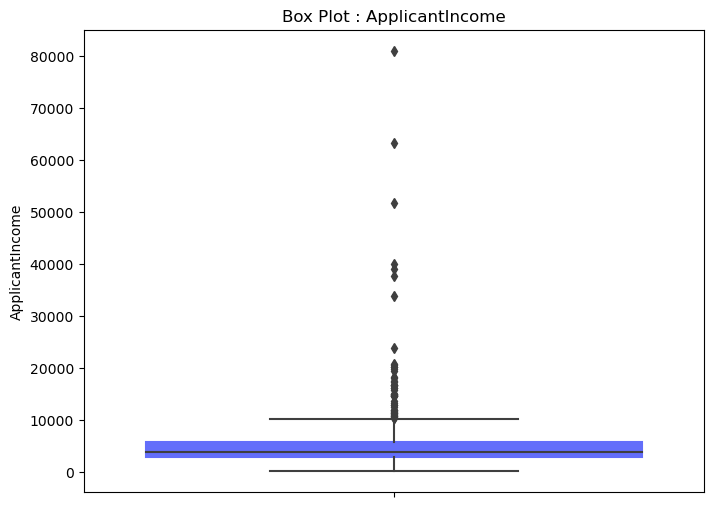

In [15]:
#On trace un Histogramme et un Boxplot pour le revenu de l'emprunteur
plt.figure(figsize=(8, 6))
sns.histplot(train_data['ApplicantIncome'], kde=True, color='#636EFA' )
plt.title('Histogramme : Revenu du demandeur (AppliantIncome)')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['ApplicantIncome'], boxprops=dict(color='#636EFA'))
plt.title('Box Plot : ApplicantIncome')
plt.show()

J'ai mis **ci-dessous** un exemple d'histogramme pour une loi gaussienne (normale) on voit que notre courbe respecte à peu près la même variance malgré le peu de données du dataset (600 lignes) ce qui nous rassure pour la suite de notre modèle même si on peut voir quelques outliers particulièrement sur le Box Plot, on va les traiter à la prochaine étape pour voir une véritable évolution de la précision des modèles au fûr et à mesure
![Histogrammeviolet](image/Histogrammeviolet.png)

# Prétraitement des données

Dans cette partie on va s'occuper du prétraitement des données en traitant les Outliers, en gérant les valeurs manquantes, en encodant les colonne non numérique, en normalisant les colonnes numériques

## Traitement des Outliers

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning:

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.



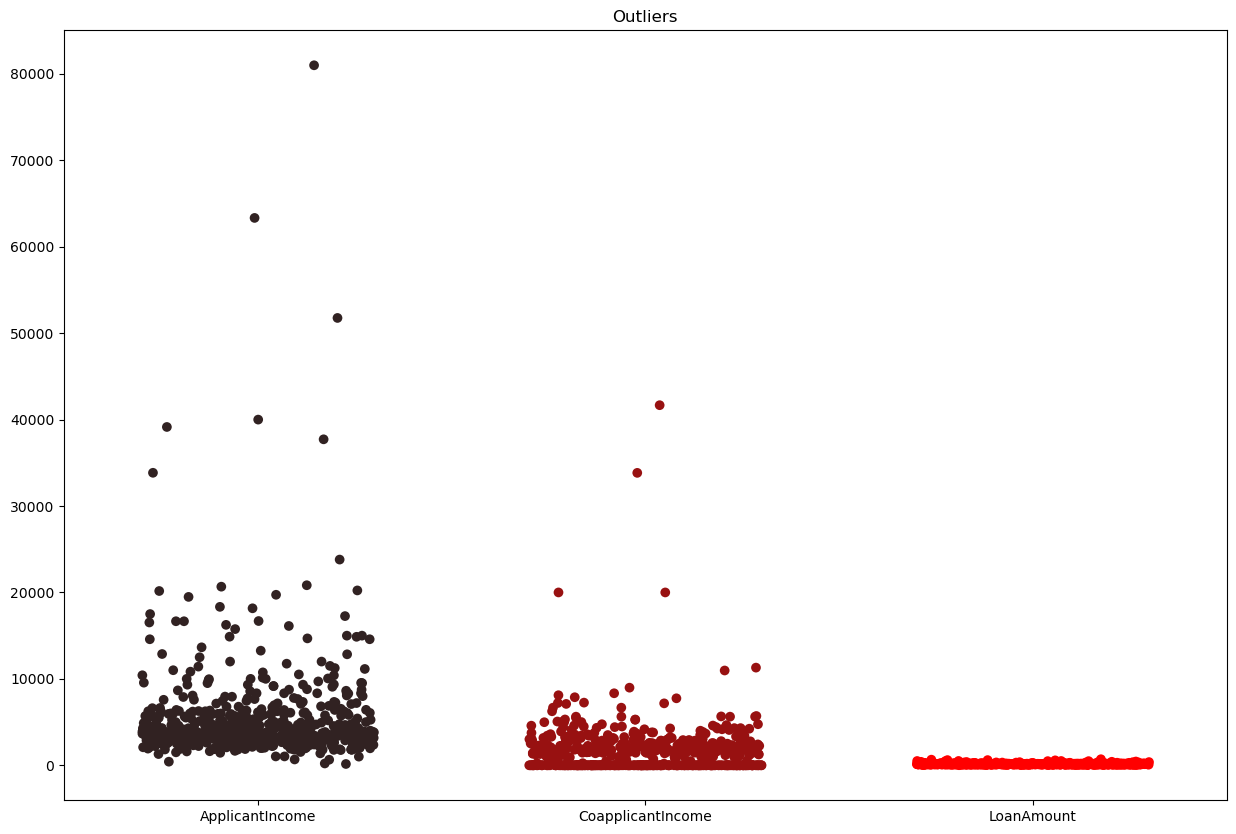

In [16]:
plt.figure(figsize=(15, 10))

#On montre les colonnes qui possède des Outliers
outliersColumns = train_data.get(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"])

#On affiche les Outliers
sns.stripplot(data=outliersColumns, color="red", jitter=0.3, size=7)
plt.title("Outliers")
plt.show()

On peut observer des Outliers dans Appliant Income et Coapplicant Income qu'on va essayer de régler

Taille des données avant suppression des outliers : (614, 13)
Taille des données après suppression des outliers : (548, 13)
Statistiques après capping :
       ApplicantIncome  CoapplicantIncome
count       548.000000         548.000000
mean       4128.978102        1359.425036
std        1907.396960        1458.228533
min         150.000000           0.000000
25%        2768.750000           0.000000
50%        3656.000000        1293.500000
75%        5000.000000        2250.000000
max       10139.000000        5701.000000


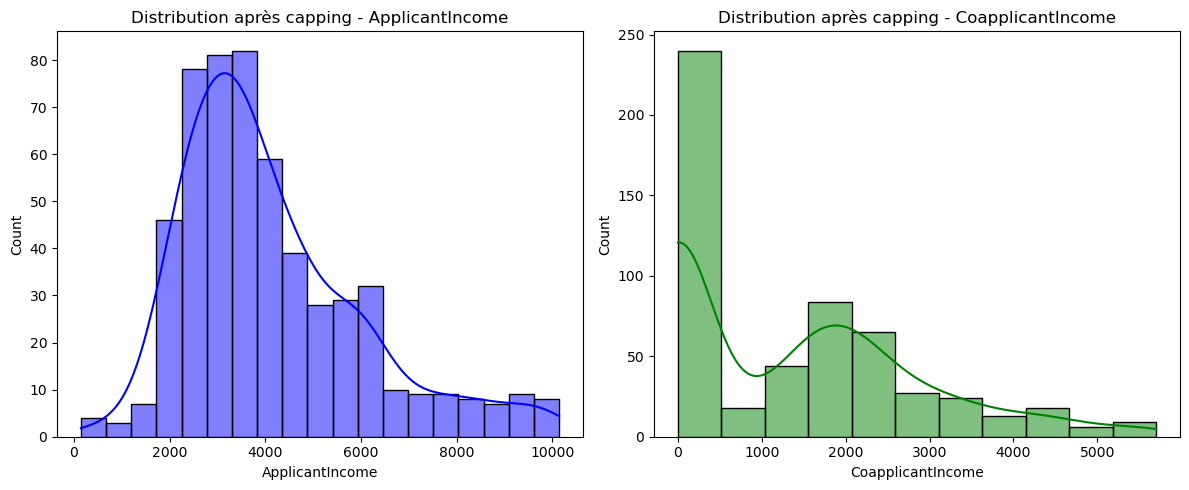

In [17]:
#Ici on va utiliser une méthode que j'ai vu sur Youtube pour gérer les Outliers On utilise l'équart inter quartiles entre
#le premier quartile et le 3ème (0,25 et 0,75)
# Calcul des quartiles
Q1 = train_data[['ApplicantIncome', 'CoapplicantIncome']].quantile(0.25)
Q3 = train_data[['ApplicantIncome', 'CoapplicantIncome']].quantile(0.75)
IQR = Q3 - Q1

#On supprime les Outliers au dessus de la fourchette de quartiles
print(f"Taille des données avant suppression des outliers : {train_data.shape}")
train_data = train_data[~((train_data[['ApplicantIncome', 'CoapplicantIncome']] < (Q1 - 1.5 * IQR)) | 
                          (train_data[['ApplicantIncome', 'CoapplicantIncome']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Taille des données après suppression des outliers : {train_data.shape}")
#On verifie les résultats
print("Statistiques après capping :")
print(train_data[['ApplicantIncome', 'CoapplicantIncome']].describe())

plt.figure(figsize=(12, 5))
#On regarde le graphique d'Appliant Income
plt.subplot(1, 2, 1)
sns.histplot(train_data['ApplicantIncome'], kde=True, color='blue')
plt.title('Distribution après capping - ApplicantIncome')
plt.xlabel('ApplicantIncome')
#On regarde le graphique de CoAppliant Income
plt.subplot(1, 2, 2)
sns.histplot(train_data['CoapplicantIncome'], kde=True, color='green')
plt.title('Distribution après capping - CoapplicantIncome')
plt.xlabel('CoapplicantIncome')
plt.tight_layout()
plt.show()

On voit qu'on a supprimer quasiment 60 lignes de 614 on est passé à 548 mais la courbe d'Appliant Income est beaucoup plus réaliste que celle de tout à l'heure et à part le pique qu'on a sur CoAppliant Income entre 0 et 500 la courbe suit presque la même chose

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning:

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.



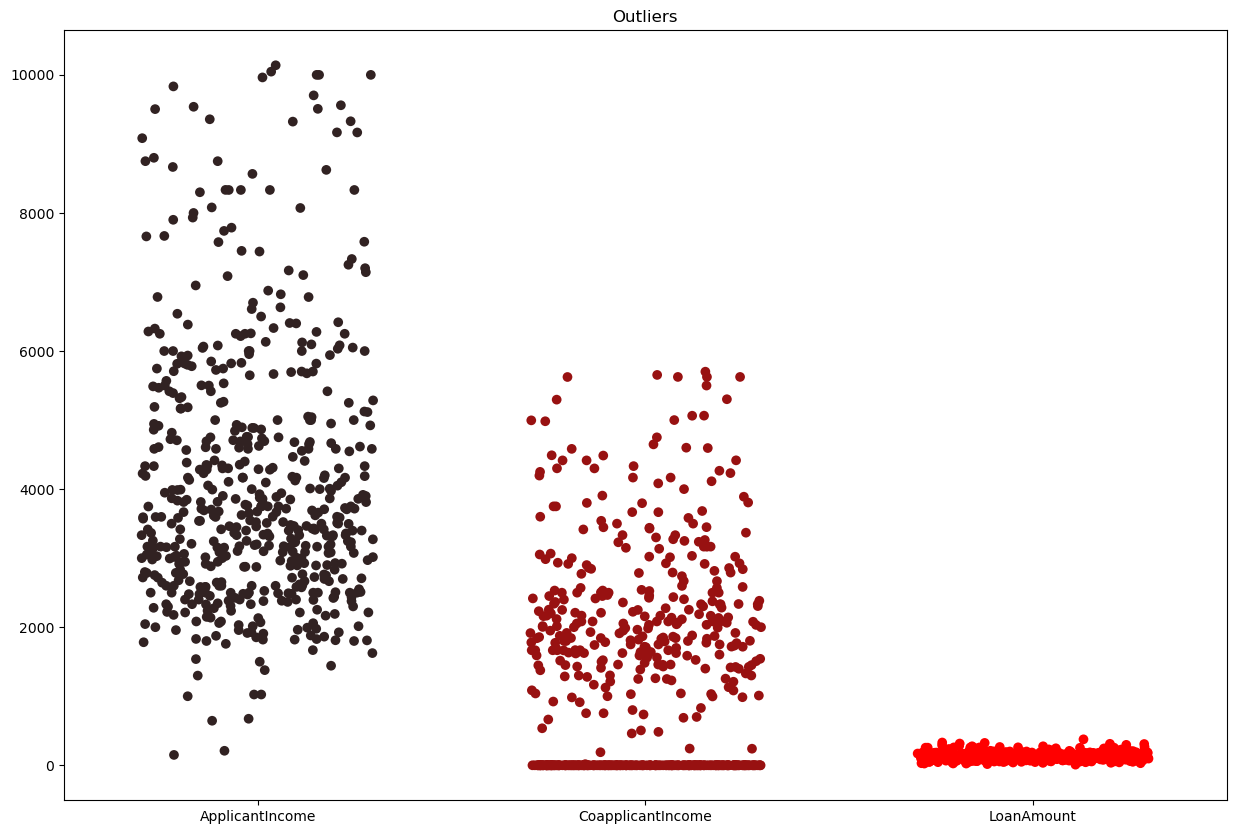

In [18]:
#Boxplot
plt.figure(figsize=(15, 10))
outliersColumns = train_data.get(["ApplicantIncome", "CoapplicantIncome", "LoanAmount"])
sns.stripplot(data=outliersColumns, color="red", jitter=0.3, size=7)
plt.title("Outliers")
plt.show()

On observe une meilleure configuration de la répartition des données

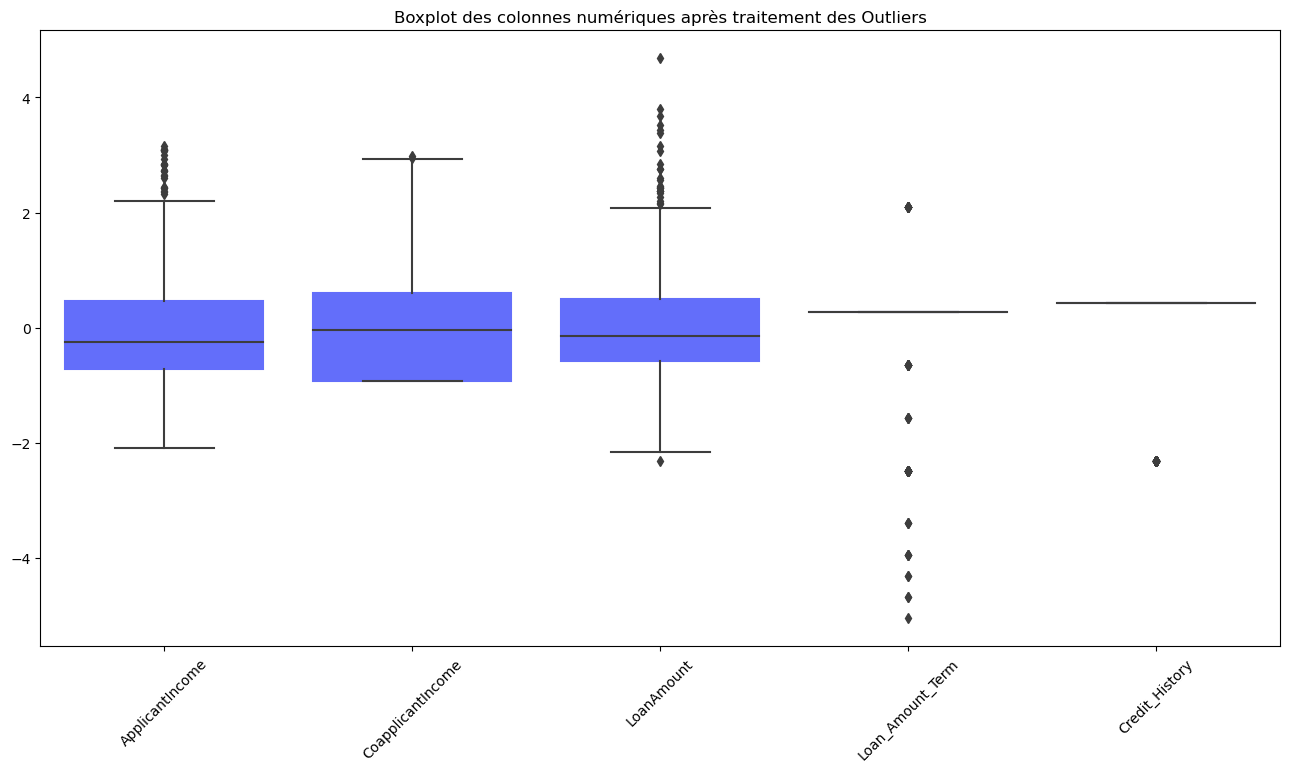

In [19]:
#On standardise les données seulement numérique
numeric_cols = train_data.select_dtypes(include=[float, int])

#On supprime la colonne Lona_Status_numeric
numeric_cols = numeric_cols.drop(columns=['Loan_Status_numeric'], errors='ignore')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_cols)

#On convertie les données en DataFrame pour pouvoir avoir le graphique
scaled_df = pd.DataFrame(scaled_data, columns=numeric_cols.drop(columns=['Loan_Status_numeric'], errors='ignore').columns)
#Tracer un boxplot standardisé
plt.figure(figsize=(16, 8))
sns.boxplot(data=scaled_df, boxprops=dict(color='#636EFA'))
plt.title("Boxplot des colonnes numériques après traitement des Outliers")
plt.xticks(rotation=45)
plt.show()

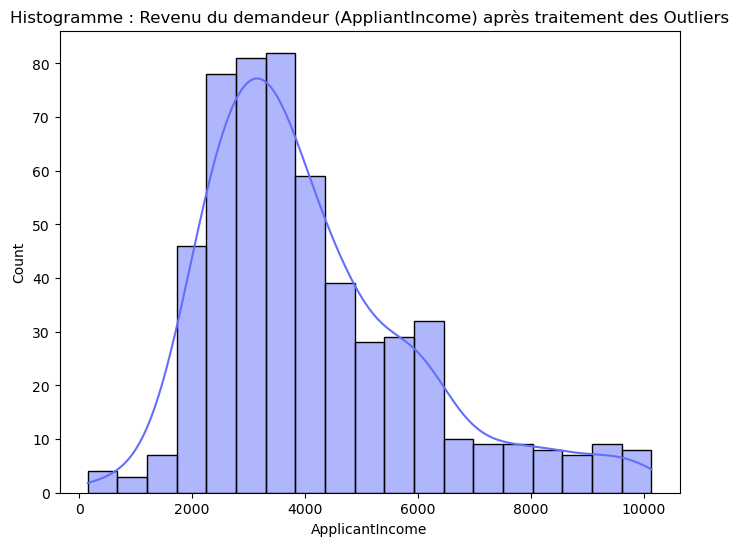

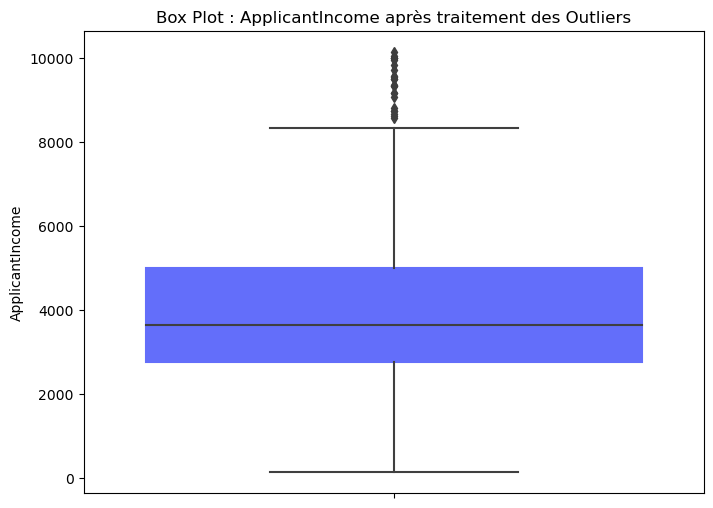

In [20]:
#On trace un Histogramme et un Boxplot pour le revenu de l'emprunteur
plt.figure(figsize=(8, 6))
sns.histplot(train_data['ApplicantIncome'], kde=True, color='#636EFA' )
plt.title('Histogramme : Revenu du demandeur (AppliantIncome) après traitement des Outliers')
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(y=train_data['ApplicantIncome'], boxprops=dict(color='#636EFA'))
plt.title('Box Plot : ApplicantIncome après traitement des Outliers')
plt.show()

On voit bien que notre répartition suit la courbe de loi normale/gaussienne donc c'est cohérent

## Traitement des valeurs manquantes

In [21]:
missing_value_train=train_data.isnull().sum()
missing_value_test=test_data.isnull().sum()
print("Nombre de valeurs manquantes dans l'entrainement:\n", missing_value_train)
print("Nombre de valeurs manquantes dans le test:\n", missing_value_test)

Nombre de valeurs manquantes dans l'entrainement:
 Loan_ID               0
Gender               10
Married               3
Dependents           14
Education             0
Self_Employed        29
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     14
Credit_History       45
Property_Area         0
Loan_Status           0
dtype: int64
Nombre de valeurs manquantes dans le test:
 Loan_ID               0
Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64


On observe des valeurs manquantes dans `Gender`,`Married`,`Dependants`,`Self_Employed`,`LoanAmount`,`Loan_Amount_Term` et `Credit_History ` dans notre jeu d'entrainement

On observe des valeurs manquantes dans `Gender`,`Dependents`,`Self_Employed`,`LoanAmount`,`Loan_Amount_Term` et `Credit_History` dans notre jeu de test

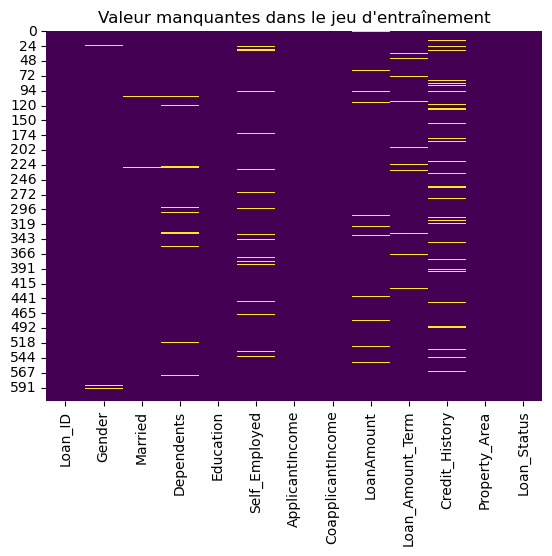

In [22]:
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Valeur manquantes dans le jeu d'entraînement")
plt.show()

On observe la répartition des valeurs manquantes en fonction des colonnes

In [23]:
#On va s'occuper des valeurs manquantes du dataset train et du test
train_data['LoanAmount'].fillna(train_data['LoanAmount'].median(), inplace=True)#Ici on utiilise la mediane de la colonne pour remplacer les valeurs manquates
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].mode()[0], inplace=True)#Le mode remplace par la valeur qui apparait le plus souvent dans la colonne je trouve que c'est un bon choix genéralement les clients rembourse leur prêt souvent sur des mêmes durée
train_data['Credit_History'].fillna(train_data['Credit_History'].mode()[0], inplace=True)#Même chose on remplace par la valeur qui est la plus fréquente dans la colonne
#Maintenant le test
test_data['LoanAmount'].fillna(test_data['LoanAmount'].median(), inplace=True)
test_data['Loan_Amount_Term'].fillna(test_data['Loan_Amount_Term'].mode()[0], inplace=True)
test_data['Credit_History'].fillna(test_data['Credit_History'].mode()[0], inplace=True)
#Maintenant on s'occupe des colonnes qui ont prennent au maximum 4 valeurs différentes :(Gender:Male ou Femelle [2 valeurs];Married:Oui ou Non[2 valeurs],Dependents:0 ou 1 ou 2 ou 3+[4 valeurs],SelfEmployed : Oui ou Non[2valeurs])
#Et on leur attribue la valeur la plus utilisé dans la colonne
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    test_data[col].fillna(test_data[col].mode()[0], inplace=True)
#On affiche les données pour voir s'il nous reste des valeurs manquantes
print("Valeur manquantes dans le Train après l'insertion:\n",train_data.isnull().sum())
print("Valeur manquantes dans le Test après l'insertion:\n",test_data.isnull().sum())

Valeur manquantes dans le Train après l'insertion:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
Valeur manquantes dans le Test après l'insertion:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
dtype: int64


1. Colonnes numériques :

- `LoanAmount` : On a choisi de remplacer les valeurs manquantes par la médiane, c'est généralement un bon choix pour ne pas avoir une variance trop élevé dans les données en imputant des valeurs manquantes

- `Loan_Amount_Term` : Ici on à plutot choisi de mettre la valeur qui apparaissait le plus

2. Colonnes catégoriques :

- Pour les colonnes qui ont un nombre limité de choix : `Gender`,`Married`,`Self_Employed` et `Depedents` (entre 2 à 4 Exemple : Homme ou Femme; Marié oui ou non; Self employed oui ou non; Nombres de personnes dépendantes 

3. Validation des données :

- On vérifie que toutes les valeurs manquante sont été traitées, c'est le cas

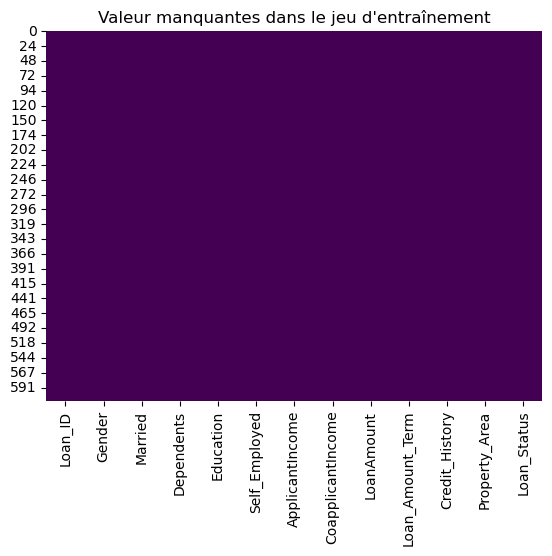

In [24]:
sns.heatmap(train_data.isnull(), cbar=False, cmap='viridis')
plt.title("Valeur manquantes dans le jeu d'entraînement")
plt.show()

## Transformation des colonnes catégorielle en étiquette binaire

Nous devons également transformer les colonnes catégorielles en colonnes binaires pour rendre les données exploitables par les algorithmes de machine learning. Ces algorithmes fonctionnent uniquement avec des données numériques et ne peuvent pas interpréter directement des variables non numériques comme du texte ou des catégories.

In [25]:
#On va utiliser pd.get_dummies pour transformer les colonnes non numériques en colonne binaire
train_data=pd.get_dummies(train_data, columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'], drop_first=True)
test_data=pd.get_dummies(test_data, columns=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'], drop_first=True)

## Normalisation des données

In [26]:
#On va utiliser la méthode du Z-score (pour avoir une moyenne de 0 et une variance de 1 donc en gros theroeme central limite on veut avoir une foncition gaussienne)
#Formule :Valeur-Moyenne/EcartType
train_data['ApplicantIncome'] = (train_data['ApplicantIncome'] - train_data['ApplicantIncome'].mean()) / train_data['ApplicantIncome'].std()
train_data['CoapplicantIncome'] = (train_data['CoapplicantIncome'] - train_data['CoapplicantIncome'].mean()) / train_data['CoapplicantIncome'].std()
train_data['LoanAmount'] = (train_data['LoanAmount'] - train_data['LoanAmount'].mean()) / train_data['LoanAmount'].std()
test_data['ApplicantIncome'] = (test_data['ApplicantIncome'] - test_data['ApplicantIncome'].mean()) / test_data['ApplicantIncome'].std()
test_data['CoapplicantIncome'] = (test_data['CoapplicantIncome'] - test_data['CoapplicantIncome'].mean()) / test_data['CoapplicantIncome'].std()
test_data['LoanAmount'] = (test_data['LoanAmount'] - test_data['LoanAmount'].mean()) / test_data['LoanAmount'].std()

On utilise la méthode du **Z-Score** qui consiste à avoir une variance/ecart-type de 1 et une moyenne de 0 c'est le <u>Théorème Central-Limite</u> voici la formule :
![Zscore](image/Zscore.png)

# Exploration Qualitatives des Données

## Recherche des caractéristiques influentes pour notre modèle

À présent on réalise une analyse des caractéristiques influentes de notre dataset pour identifier les variables ayant le plus d’impact sur l’acceptation des prêts `Loan_Status`. 
Nous allons à travers une matrice de corrélation et une analyse ciblée par rapport à la cible évaluer les relations entre les variables et leur pertinence pour le modèle.

In [27]:
corr_matrix = train_data.select_dtypes(["int","float"]).corr()

<Axes: title={'center': 'Matrice de Corrélation'}>

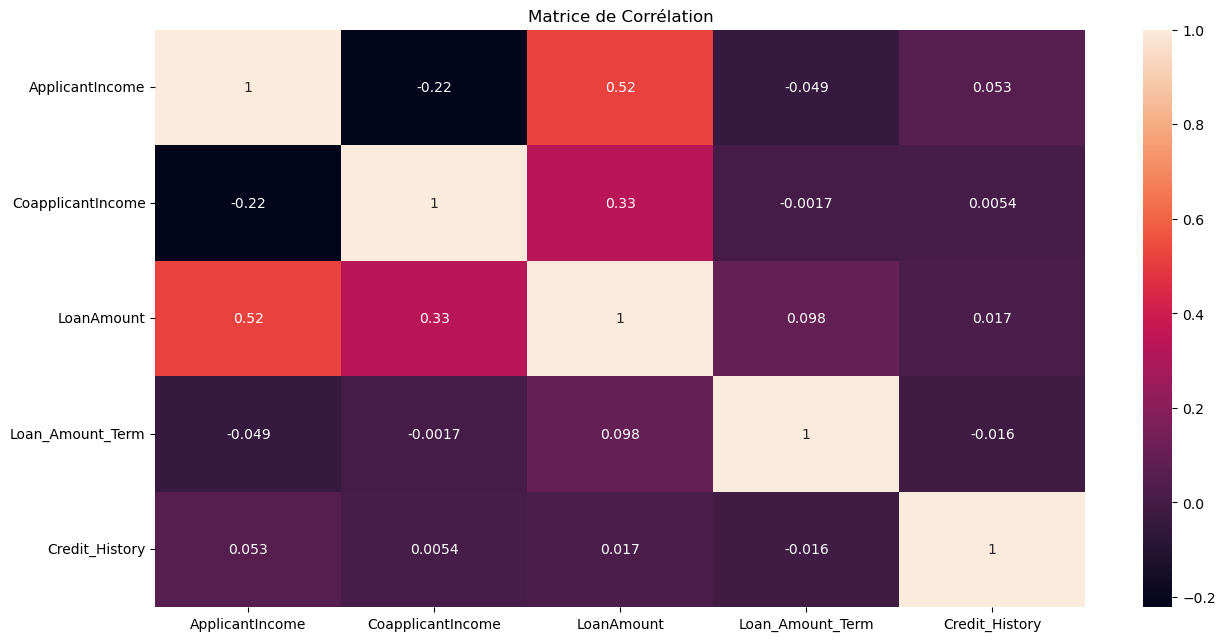

In [28]:
plt.figure(figsize=(15, 7.5))
plt.title("Matrice de Corrélation")
sns.heatmap(corr_matrix,annot=True)

On a une correlation positive (0,52) entre `LoanAmount` et `ApplicantIncome` on en déduit que plus le montant du prêt est élévé plus les revenus du client qui demande le prêt devrons être élevé ce qui est logique en soit.

On a une correlation positive (0,33) mais pas très grande on peut donc en déduire que les revenus du "Co-demandeur" du prêt n'ont pas un très gros impact dans le montant du prêt.

On a également une correlation negative (-0,22) entre les revenus du Demandeur et du Codemandeur mais ça n'a rien à voir.

Les autres correlations sont autour de 0 toutes inferieure à 0,6 ce qui indique qu'elles semblement indépendante les unes des autres.

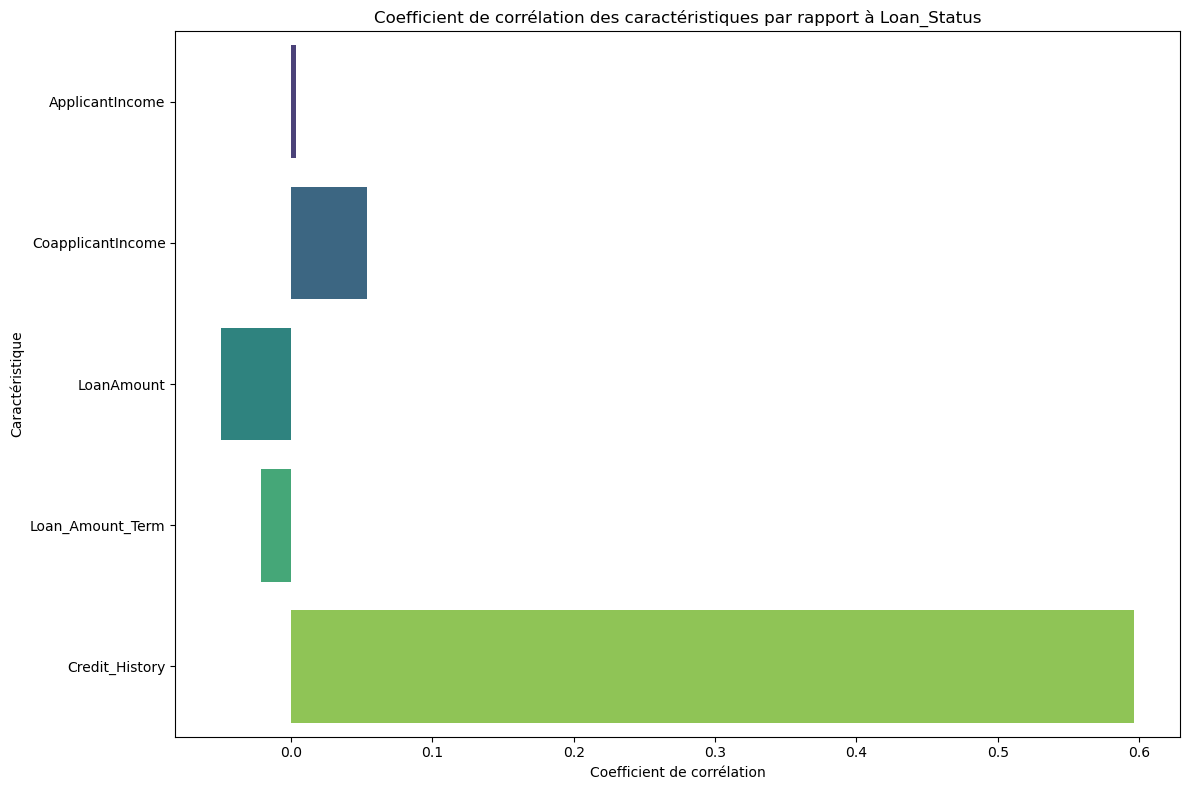

In [29]:
#On crée une copie du dataframe pour pouvoir voir les correlations par colonne
corr_data = train_data.copy()

#On corrélle par rapport à la colonne d'acceptation du prêt
corr_data['Loan_Status_numeric'] = corr_data['Loan_Status'].map({'Y': 1, 'N': 0})

#On prend uniquement les colonnes numériques
numeric_df = corr_data.select_dtypes(include=[float, int])
corr_matrix = numeric_df.corr()
corr_with_target = corr_matrix['Loan_Status_numeric'].drop('Loan_Status_numeric')

#On convertie en Dataframe pour pouvoir l'afficher
corr_with_target_df = corr_with_target.reset_index()
corr_with_target_df.columns = ['Feature', 'Correlation']
plt.figure(figsize=(12, 8))
sns.barplot(data=corr_with_target_df, x='Correlation', y='Feature', palette='viridis')
plt.title('Coefficient de corrélation des caractéristiques par rapport à Loan_Status')
plt.xlabel('Coefficient de corrélation')
plt.ylabel('Caractéristique')
plt.tight_layout()
plt.show()

Ce graphique permet d'identifier quelles colonnes ou variables influencent le plus la décision d'acceptation d'un prêt
On voit que le Credit History à un impact colossal, ce qui paraît logique, plus une personne aura un bon historique de prêt bancaire plus elle sera à même d'être accepté

**Correlation Postive : Quand la variable X monte Y monte aussi**

**Correlation Négative : Quand la variable X monte Y descend**

**Proche de 0 : LA variable X et Y ne sont pas corrélées**

`Credit_History` : Corrélé positivement donc plus une personne à un bon historique de prêt plus il aura de chance d'être accepté

`CoApplicantIncome` : Légérement corrélé négativement

`LoanAmount` : Correlation presque nulle

`Loan_Amount_Term` : Correlation presque nulle

`Applicant Income` : Correlation presque nulle

On peut voir un biais ici le salaire du demandeur n'a pratiquement pas d'impact et celui du co demandeur à un leger impact dans le choix d'acceptation du prêt alors que normalement c'est censé être un facteur qui est pertinent, donc ça me perturbe pas mal  ça doit venir du dataset

# Entrainement des modèles

Dans cette partie on va utiliser les différents modèles vu en classe en cherchant les hyperpamètres les plus optimaux pour chacun des modèles en calculant les Accuracy les rapports de classification et les matrices de confusion

In [30]:
#Préparation des données
X = train_data.drop(columns=['Loan_Status', 'Loan_ID'])
y = train_data['Loan_Status']
X = pd.get_dummies(X, drop_first=True)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#On applique le standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#On split le train 2 en un train et un test (pas le test du debut lui il servrira à la prediction finale)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Modèles et Hyperparamètres

On affiche les Hyperpamètres des différents modèles qu'on va utiliser :

In [31]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [32]:
LinearRegression().get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [33]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [34]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [35]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [36]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [37]:
BernoulliNB().get_params()

{'alpha': 1.0,
 'binarize': 0.0,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': True}

In [38]:
GaussianNB().get_params()

{'priors': None, 'var_smoothing': 1e-09}

### Recherche des Meilleurs Hyperparamètres

Pour optimiser les performances de nos modèles, on va tester les modèles avec des boucles for qui testeront pleins de combinaisons d'hyperparamètres jusqu'a trouver la meilleure.

Le modèle est évalué pour chaque combinaison, et nous identifions les hyperparamètres qui donnent la meilleure **accuracy** ou d'autres métriques comme le **F1-score**.

## Régression Logistique

In [39]:
%pip install shap

Meilleurs paramètres : random_state=1, max_iter=50, C=0.1
Meilleure accuracy (Validation): 89.09%
Accuracy finale avec les meilleurs paramètres : 89.09%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.87      1.00      0.93        77

    accuracy                           0.89       110
   macro avg       0.93      0.82      0.85       110
weighted avg       0.91      0.89      0.88       110



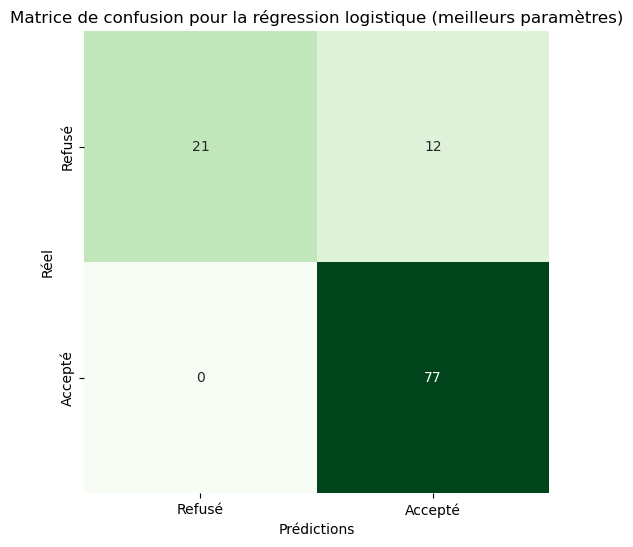

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109]
Indices des Faux Négatifs (FN) : []


In [40]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
scoreListLR_Train = []
scoreListLR_Test = []
best_params = None
best_accuracy = 0

#Boucles pour les Hyperparamètres
for random_state in range(1, 51):  #On teste des random de 1 à 50
    for max_iter in range(50, 501, 50):  #On teste des itérations max de 50 en 50 jusqu'à 500
        for c in [0.01, 0.1, 1.0, 10.0, 100.0]:  #On teste des valeurs de C
            #Créer et entraîner le modèle
            log_reg = LogisticRegression(random_state=random_state, max_iter=max_iter, C=c, solver='lbfgs')
            log_reg.fit(X_train, y_train)
            
            #On fait les prédictions
            y_pred_train = log_reg.predict(X_train)
            y_pred_test = log_reg.predict(X_val)
            
            #Accuracy sur l'entraînement et la validation
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_test)
            
            #On rajoute les scores aux différentes listes
            scoreListLR_Train.append(train_acc)
            scoreListLR_Test.append(val_acc)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (random_state, max_iter, c)

#On affiche les résultats
print(f"Meilleurs paramètres : random_state={best_params[0]}, max_iter={best_params[1]}, C={best_params[2]}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")

#Entraîner un modèle final avec les meilleurs paramètres
best_log_reg = LogisticRegression(random_state=best_params[0], max_iter=best_params[1], C=best_params[2], solver='lbfgs')
best_log_reg.fit(X_train, y_train)

# Prédictions finales
y_pred_best = best_log_reg.predict(X_val)

#On obtient le rapport de Classification et l'accuracy
accuracy_lr_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_lr_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Matrice de confusion
confusion_matrix_best_lr = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_best_lr, annot=True, fmt='g', cmap='Greens', cbar=False,
            yticklabels=['Refusé', 'Accepté'], xticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour la régression logistique (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

#Identifier les faux positifs (FP) et faux négatifs (FN)
fp_indices_log_reg = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_log_reg = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]

print(f"Indices des Faux Positifs (FP) : {fp_indices_log_reg}")
print(f"Indices des Faux Négatifs (FN) : {fn_indices_log_reg}")

Le modèle de `Régression logistique` a correctement prédit que **21 prêts** seraient **refusés** et que **77 prêts** seraient **acceptés** mais il a mal prédit en disant que **12 prêts** seraient **acceptés** alors qu'ils ont été **refusés**.

Analyse des faux positifs avec SHAP...


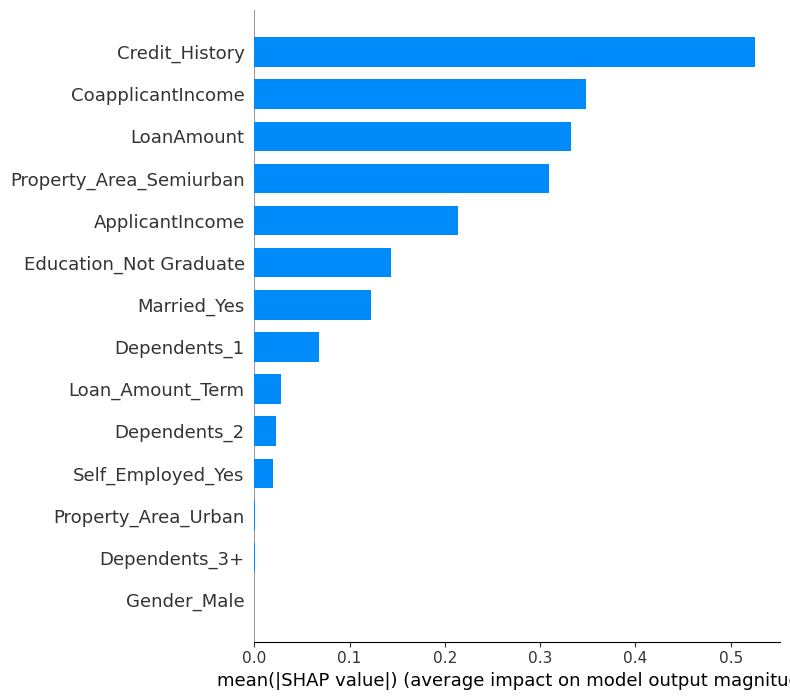

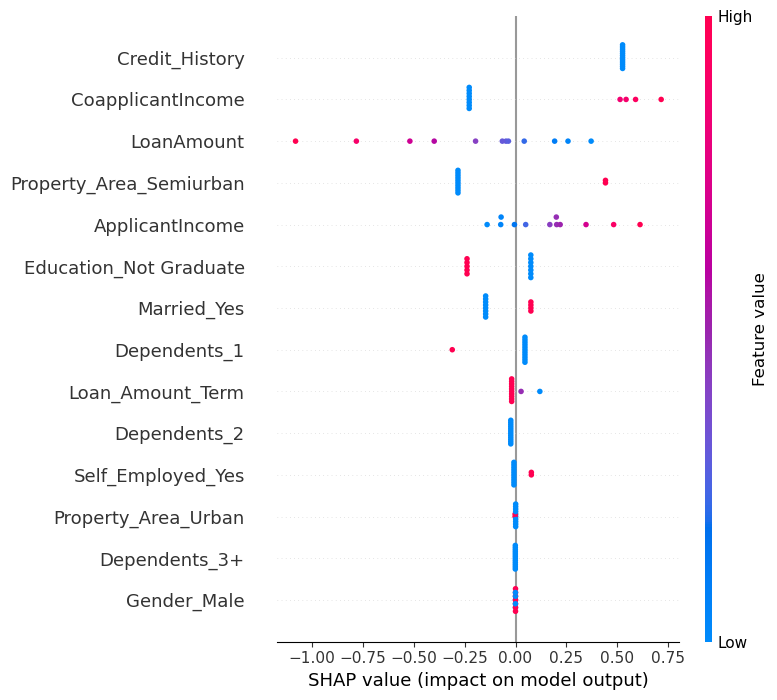

In [41]:
import shap

# Préparer les données pour les faux positifs
X_val_fp = X_val[fp_indices_log_reg]

# SHAP pour les faux positifs
print("Analyse des faux positifs avec SHAP...")
explainer = shap.Explainer(best_log_reg, X_train)
shap_values = explainer(X_val_fp)

# Graphique SHAP global
shap.summary_plot(shap_values, X_val_fp, plot_type="bar", feature_names=X.columns)

# Graphique SHAP distribution
shap.summary_plot(shap_values, X_val_fp, feature_names=X.columns)

## AI explanability :
On peut voir que l'historique de crédit du client joue énormément dans la décision d'acceptation du prêt comme vu tout à l'heure sur ce modèle de `Régression logistique` suivi des revenus du Codemandeur suivis du montant du Crédit

## Régression Linéaire

Normalement la régression linéaire n'est que pour les valeur continue or nous on a besoin d'un Oui ou d'un Non pour l'acceptation du prêt donc une méthode existante consiste à dire que toutes les valeurs au dessus ou égal à 0,5 sont jugées comme un 1 (prêt accepté) et celle inférieure son traitées comme des 0 (prêt refusé) on traite le problème avec des probabilités continue pour en obtenir des discrètes si on veut

Meilleur seuil : 0.70
Meilleure accuracy (Validation): 90.00%

Rapport de classification avec le seuil optimal (0.70) :

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        33
           1       0.92      0.94      0.93        77

    accuracy                           0.90       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.90      0.90      0.90       110



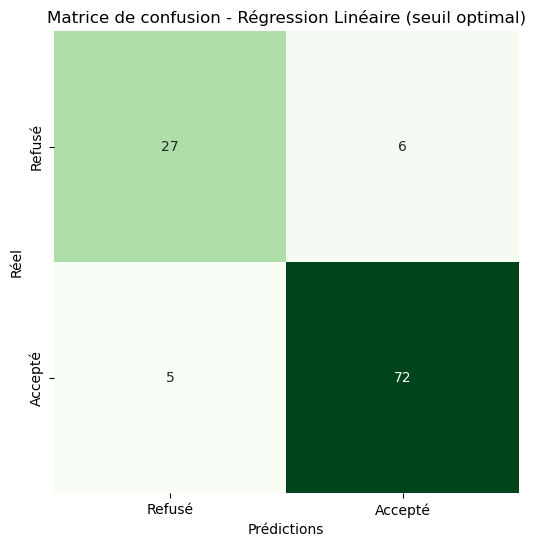

Indices des Faux Négatifs (FN): [5, 59, 86, 95, 102]


In [42]:
#On initialise les listes pour comparer les Accuracy
thresholds = np.linspace(0.1, 0.9, 9)  #On teste des seuils entre 0.1 et 0.9
train_accuracies = []
val_accuracies = []
best_threshold = None
best_accuracy = 0

#Entraînement du modèle
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Prédictions
y_pred_train_continuous = lin_reg.predict(X_train)
y_pred_val_continuous = lin_reg.predict(X_val)

#Boucle pour trouver le meilleur seuil
for threshold in thresholds:
    #Conversion des prédictions continues en binaire
    y_train_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_train_continuous]
    y_val_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_val_continuous]

    #Calcul des Accuracy
    train_acc = accuracy_score(y_train, y_train_pred_binary)
    val_acc = accuracy_score(y_val, y_val_pred_binary)

    #Mise à jour des meilleurs paramètres
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_threshold = threshold
accuracy_lin_val = best_accuracy
#Résultats finaux
print(f"Meilleur seuil : {best_threshold:.2f}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")
y_val_pred_best = [1 if pred >= best_threshold else 0 for pred in y_pred_val_continuous]

#On obtient le rapport de Classification et l'accuracy
print(f"\nRapport de classification avec le seuil optimal ({best_threshold:.2f}) :\n")
print(classification_report(y_val, y_val_pred_best))

#Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_val_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Refusé', 'Accepté'], yticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion - Régression Linéaire (seuil optimal)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

#Identifier les indices des Faux Négatifs (FN)
fn_indices_lin_reg = [i for i, (true, pred) in enumerate(zip(y_val, y_val_pred_best)) if true == 1 and pred == 0]
fp_indices_lin_reg = [i for i, (true, pred) in enumerate(zip(y_val, y_val_pred_best)) if true == 0 and pred == 1]
print(f"Indices des Faux Négatifs (FN): {fn_indices_lin_reg}")

On observe une très bonne accuracy, 9 fois sur 10 le modèle prédit bien si le prêt est accepté ou non. A première vu on a une  pluôt bonne prédiction sur la classe 0 (prêt refusé) et bonne sur la classe 1 prêt accepté

Le modèle de `Régression linéaire` à prédit :

- **27 Vrais négatifs** : Le modèle a correctement prédit que 27 prêts seraient refusés.

- **6 Faux positifs** : 6 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **5 Faux négatif** : 5 prêts ont été refusés alors qu'ils auraient dû être acceptés.

- **72 Vrais positifs** : Le modèle a correctement prédit que 72 prêts seraient acceptés.

Analyse des faux négatifs avec SHAP...


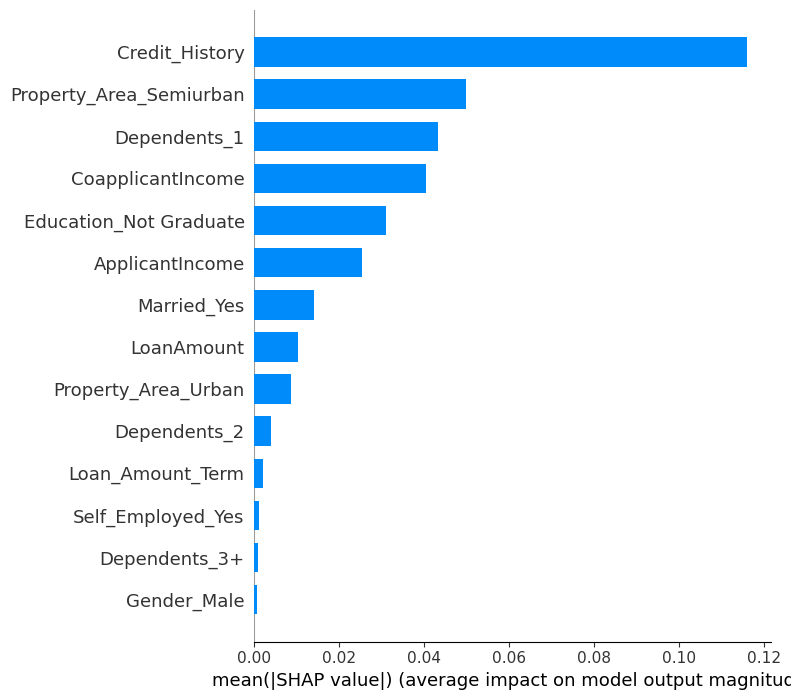

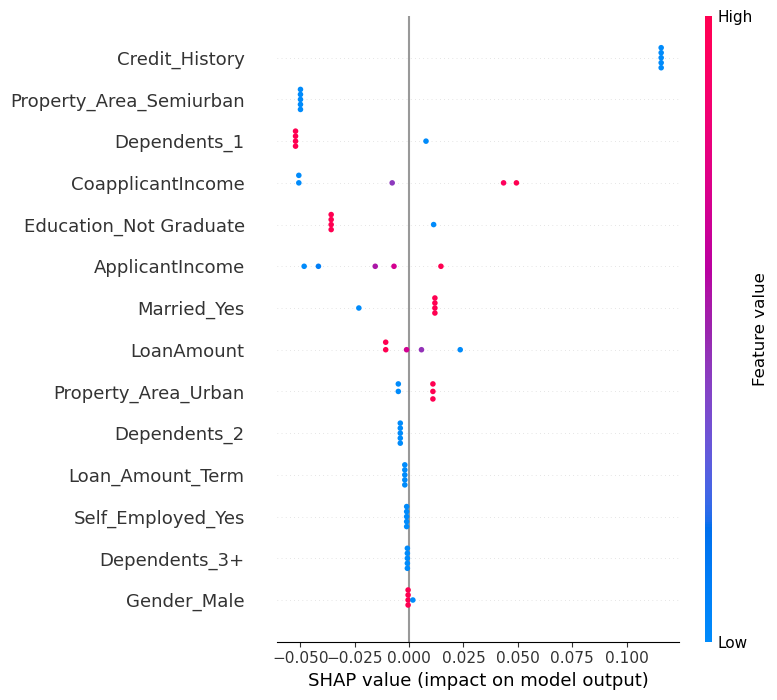

In [43]:
import shap

# Préparer les données pour les faux négatifs
X_val_fn = X_val[fn_indices_lin_reg]

# SHAP pour les faux négatifs
print("Analyse des faux négatifs avec SHAP...")
explainer = shap.Explainer(lin_reg, X_train)
shap_values = explainer(X_val_fn)

# Graphique SHAP global
shap.summary_plot(shap_values, X_val_fn, plot_type="bar", feature_names=X.columns)

# Graphique SHAP distribution
shap.summary_plot(shap_values, X_val_fn, feature_names=X.columns)

## Ai explanability :
Pour le modèle de `Régression linéaire` on remarque que les variables qui rentrent le plus en compte dans le choix d'acceptation du prêt sont l'Historique de Crédit du demandeur, puis l'emplacement du logement de la personne et si une personne est garant du prêt

## KNN (K-Nearest-Neighbors)

Meilleurs paramètres : n_neighbors=9, weights=uniform, p=2
Meilleure accuracy (Validation): 86.36%
Accuracy finale avec les meilleurs paramètres : 86.36%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.55      0.71        33
           1       0.84      1.00      0.91        77

    accuracy                           0.86       110
   macro avg       0.92      0.77      0.81       110
weighted avg       0.89      0.86      0.85       110

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 63, 65, 68, 73, 74, 108, 109]


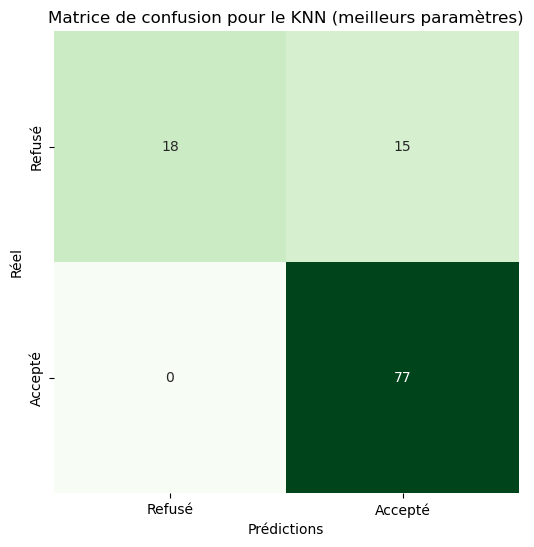

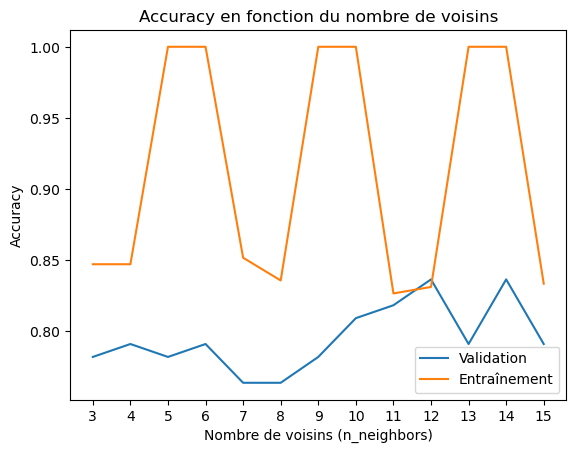

In [44]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
scoreListKNN_Train = []
scoreListKNN_Test = []
best_params = None
best_accuracy = 0
#Boucles pour trouver la meilleure combinaison
for n_neighbors in range(3, 16):  #On teste avec des voisins de 3 à 16
    for weights in ['uniform', 'distance']:
        for p in [1, 2]:  #L1 (Manhattan) ou L2 (Euclidean)
            #Créer et entraîner le modèle
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
            knn.fit(X_train, y_train)
            
            #Prédictions
            y_pred_train = knn.predict(X_train)
            y_pred_test = knn.predict(X_val)
            
            #Accuracy sur les ensembles d'entraînement et de validation
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_test)
            
            #Mise à jour des meilleurs paramètres si nécessaire
            scoreListKNN_Train.append(train_acc)
            scoreListKNN_Test.append(val_acc)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (n_neighbors, weights, p)
#Résultats finaux
print(f"Meilleurs paramètres : n_neighbors={best_params[0]}, weights={best_params[1]}, p={best_params[2]}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")
best_knn = KNeighborsClassifier(n_neighbors=best_params[0], weights=best_params[1], p=best_params[2])
best_knn.fit(X_train, y_train)
#Prédictions finales
y_pred_best = best_knn.predict(X_val)
#Rapport de classification
accuracy_knn_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_knn_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_knn = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_knn = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_knn}")

#Matrice de confusion
confusion_matrix_best_knn = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_best_knn, annot=True, fmt='g', cmap='Greens', cbar=False,
            yticklabels=['Refusé', 'Accepté'], xticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour le KNN (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

#On affiche les résultats
plt.plot(range(3, 16), scoreListKNN_Test[:13], label='Validation')
plt.plot(range(3, 16), scoreListKNN_Train[:13], label='Entraînement')
plt.xticks(np.arange(3, 16, 1))
plt.title("Accuracy en fonction du nombre de voisins")
plt.xlabel("Nombre de voisins (n_neighbors)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

On observe une accuracy de 86,36 %. Le modèle performe très bien pour la classe 1 (prêts acceptés) avec un recall parfait (100 %) mais montre des difficultés pour la classe 0 (prêts refusés) avec un recall faible à 55 %

Le modèle de `KNN` a prédit :

- **18 Vrais négatifs** : Le modèle a correctement prédit que 18 prêts seraient refusés.

- **15 Faux positifs** : 15 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

## Random Forest

Ce modèle prends pas mal de temps à tester les différentes combinaisons (jusqu'a 5 minutes)

Meilleurs paramètres : max_depth=7, random_state=12, n_estimators=10
Meilleure accuracy (Validation): 90.00%
Accuracy finale avec les meilleurs paramètres : 90.00%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.88      1.00      0.93        77

    accuracy                           0.90       110
   macro avg       0.94      0.83      0.87       110
weighted avg       0.91      0.90      0.89       110

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 109]


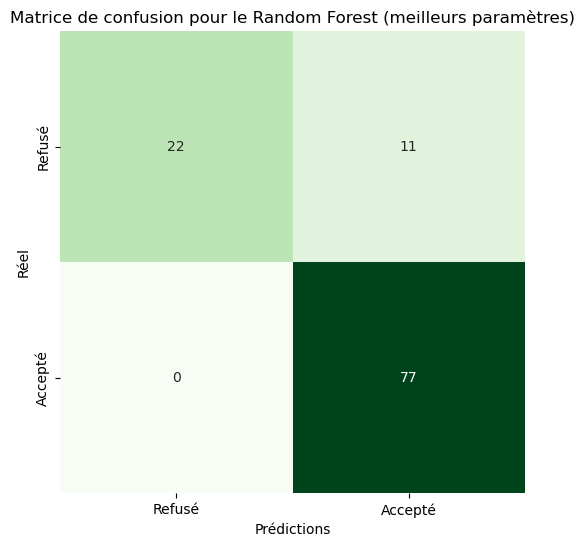

In [45]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
scoreListRF_Train = []
scoreListRF_Test = []
best_params = None
best_accuracy = 0
#Boucles pour les hyperparamètres
for max_dep in range(1, 11):  #On teste la profondeur max de 1 à 10
    for rand_state in range(1, 21):  #On teste les random state de 1 à 20
        for n_est in range(10, 101, 10):  #On teste le nombre d'estimateurs
            #Entraîner les modèles
            rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_dep, random_state=rand_state)
            rf.fit(X_train, y_train)
            
            #Prédictions
            y_pred_train = rf.predict(X_train)
            y_pred_test = rf.predict(X_val)
            
            #On calcule les Accuracys
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_test)
            
            #On compare les différents scores jusqu'a trouver le meilleur
            scoreListRF_Train.append(train_acc)
            scoreListRF_Test.append(val_acc)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (max_dep, rand_state, n_est)

#Résultats finaux
print(f"Meilleurs paramètres : max_depth={best_params[0]}, random_state={best_params[1]}, n_estimators={best_params[2]}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")

#Entraîner le modèle avec les meilleurs hyperparamètres
best_rf = RandomForestClassifier(n_estimators=best_params[2], max_depth=best_params[0], random_state=best_params[1])
best_rf.fit(X_train, y_train)

#Prédictions finales
y_pred_best = best_rf.predict(X_val)

#Rapport de classification
accuracy_rf_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_rf_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_rf = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_rf = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_rf}")

#Matrice de confusion
confusion_matrix_best_rf = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_best_rf, annot=True, fmt='g', cmap='Greens', cbar=False,
            yticklabels=['Refusé', 'Accepté'], xticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour le Random Forest (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

Le modèle Random Forest montre une très bonne accuracy on a 90%. 
La classe 1 (prêts acceptés) est parfaitement géré avec un recall de 100 %, mais la classe 0 (prêts refusés) elle, est plutôt l'opposée assez faible avec une précision de 67 %, ce qui peut biaiser le modèle en faveur des prêts acceptés.

Le modèle de `Random Forest` a prédit :

- **22 Vrais négatifs** : Le modèle a correctement prédit que 22 prêts seraient refusés.

- **11 Faux positifs** : Le modèle a prédit que 11 prêts seraient acceptés, alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

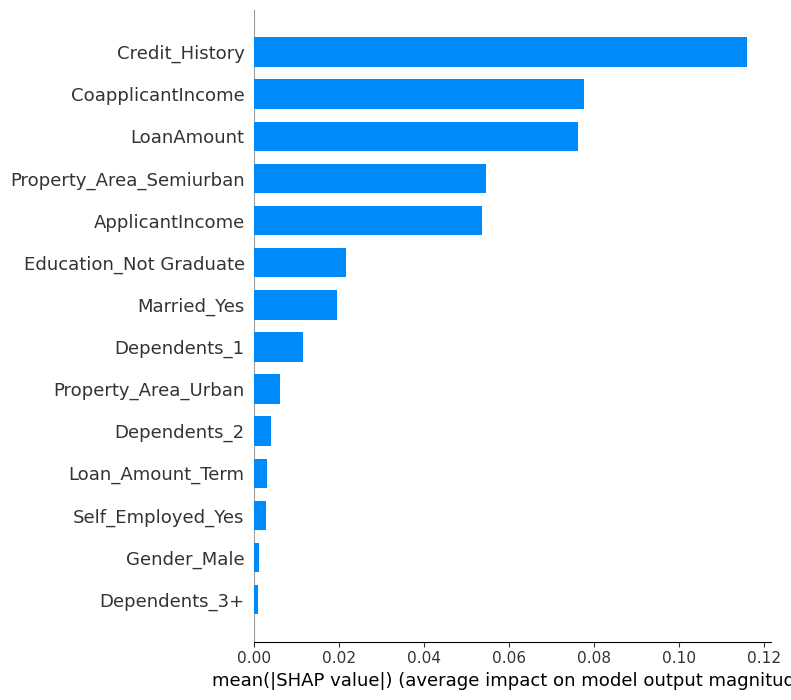

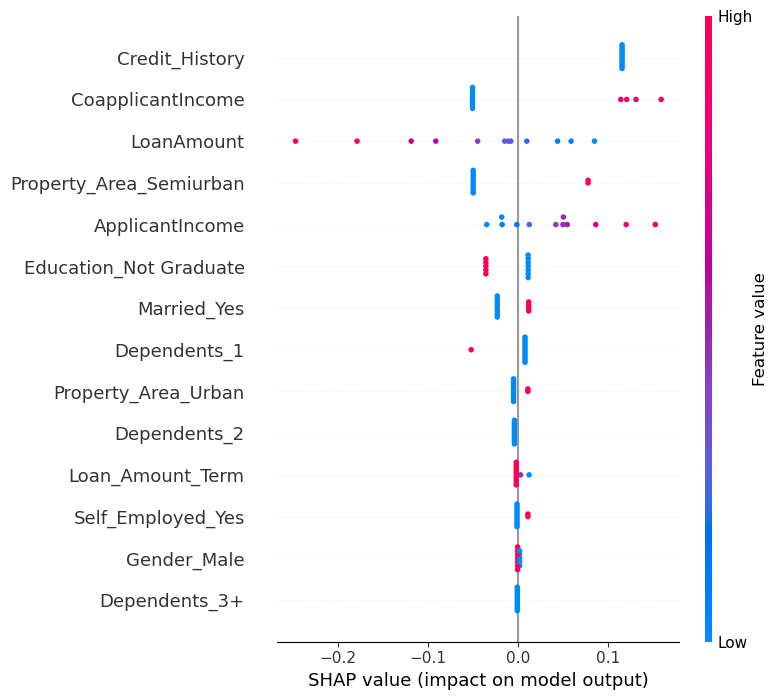

In [46]:
shap_values = explainer.shap_values(X_val_fp)

# Pour modèle binaire, vérifiez les classes et sélectionnez la classe positive
if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_values = shap_values[1]  # Classe positive

# Graphique SHAP global
shap.summary_plot(shap_values, X_val_fp, plot_type="bar", feature_names=X.columns)

# Graphique SHAP distribution
shap.summary_plot(shap_values, X_val_fp, feature_names=X.columns)

## AI explanability :
On peut voir que l'historique de crédit du client joue énormément dans la décision d'acceptation du prêt comme vu tout à l'heure sur ce modèle de `Random Forest` suivi des revenus du Codemandeur suivis du montant du Crédit

## Arbre de Décision

Meilleurs paramètres : max_depth=3, min_samples_leaf=4, max_features=7
Meilleure accuracy (Validation): 90.00%
Accuracy finale avec les meilleurs paramètres : 90.00%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.88      1.00      0.93        77

    accuracy                           0.90       110
   macro avg       0.94      0.83      0.87       110
weighted avg       0.91      0.90      0.89       110

Indices des Faux Positifs (FP) : [2, 9, 14, 34, 37, 53, 56, 65, 68, 74, 109]


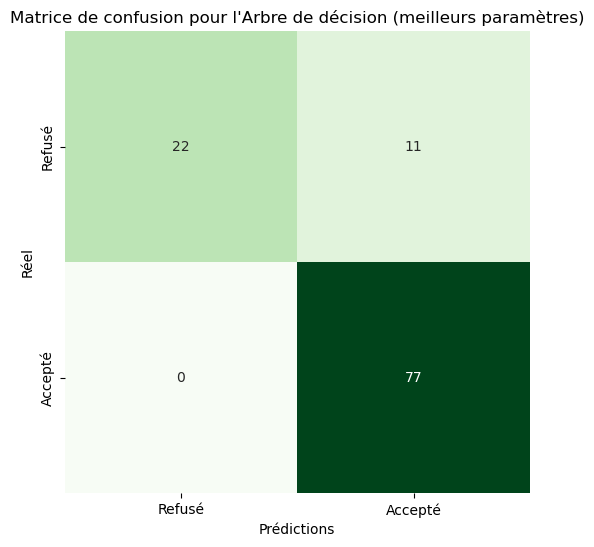

In [47]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
scoreListDT_Train = []
scoreListDT_Test = []
best_params = None
best_accuracy = 0
#Boucles pour tester les hyperparamètres
for max_dep in range(1, 21):  #On teste la profondeur max entre 1 et 20
    for min_leaf in range(1, 6):  #On teste entre 1 à 5 feuilles
        for max_feat in range(1, X_train.shape[1] + 1):  #On teste les max_features
            #Entraîner le modèle
            dt = DecisionTreeClassifier(max_depth=max_dep, min_samples_leaf=min_leaf, max_features=max_feat, random_state=42)
            dt.fit(X_train, y_train)
            
            #Prédictions
            y_pred_train = dt.predict(X_train)
            y_pred_test = dt.predict(X_val)
            
            #Calculer les Accuracy
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_test)
            
            #Comparer et mettre à jour les meilleurs paramètres
            scoreListDT_Train.append(train_acc)
            scoreListDT_Test.append(val_acc)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (max_dep, min_leaf, max_feat)

#Résultats finaux
print(f"Meilleurs paramètres : max_depth={best_params[0]}, min_samples_leaf={best_params[1]}, max_features={best_params[2]}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")

#Entraîner le modèle final avec les meilleurs paramètres
best_dt = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1], max_features=best_params[2], random_state=42)
best_dt.fit(X_train, y_train)

#Prédictions finales
y_pred_best = best_dt.predict(X_val)

#Rapport de classification
accuracy_dt_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_dt_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_dt = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_dt = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_dt}")

#Matrice de confusion
confusion_matrix_best_dt = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_best_dt, annot=True, fmt='g', cmap='Greens', cbar=False,
            yticklabels=['Refusé', 'Accepté'], xticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour l'Arbre de décision (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

L'accuracy est de 90%, ce qui indique que le modèle est très bon. Par contre le recall pour la classe 0 (67 %) à l'air un peu faible.
Alors que la classe 1 est parfaitement prédite(100%) ce qui veut dire qu'il detecte 100% des prêts acceptés en temps réel donc très bon pour le client.

Le modèle d'`Arbre de décision` a prédit :

- **22 Vrais négatifs** : Le modèle a correctement prédit que 22 prêts seraient refusés.

- **11 Faux positifs** : 11 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

## SVM

Meilleurs paramètres : kernel=linear, C=0.01, gamma=scale
Meilleure accuracy (Validation): 89.09%
Accuracy finale avec les meilleurs paramètres : 89.09%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.87      1.00      0.93        77

    accuracy                           0.89       110
   macro avg       0.93      0.82      0.85       110
weighted avg       0.91      0.89      0.88       110

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109]


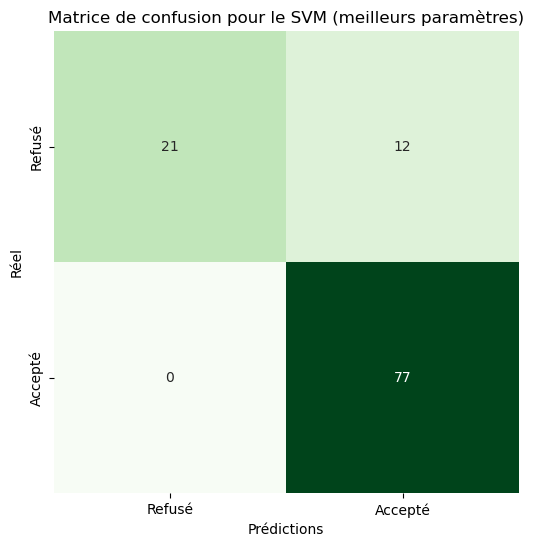

In [48]:
#Initialisation des listes pour stocker les Accuracy
scoreListSVM_Train = []
scoreListSVM_Test = []
best_params = None
best_accuracy = 0

#Boucles pour tester les hyperparamètres
for kernel in ['linear', 'rbf', 'poly']:  #Tester différents noyaux
    for c in [0.01, 0.1, 1, 10, 100]:  #Tester différentes valeurs de régularisation (C)
        for gamma in ['scale', 'auto']:  #Tester différentes stratégies pour gamma
            #Créer et entraîner le modèle
            svm_model = SVC(kernel=kernel, C=c, gamma=gamma, probability=True, random_state=42)
            svm_model.fit(X_train, y_train)
            
            #Prédictions
            y_pred_train = svm_model.predict(X_train)
            y_pred_test = svm_model.predict(X_val)
            
            #Calculer les Accuracy
            train_acc = accuracy_score(y_train, y_pred_train)
            val_acc = accuracy_score(y_val, y_pred_test)
            
            #Comparer et mettre à jour les meilleurs paramètres
            scoreListSVM_Train.append(train_acc)
            scoreListSVM_Test.append(val_acc)
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (kernel, c, gamma)

#Résultats finaux
print(f"Meilleurs paramètres : kernel={best_params[0]}, C={best_params[1]}, gamma={best_params[2]}")
print(f"Meilleure accuracy (Validation): {best_accuracy*100:.2f}%")

#Entraîner un modèle final avec les meilleurs paramètres
best_svm = SVC(kernel=best_params[0], C=best_params[1], gamma=best_params[2], probability=True, random_state=42)
best_svm.fit(X_train, y_train)

#Prédictions finales
y_pred_best = best_svm.predict(X_val)

#Rapport de classification
accuracy_svm_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_svm_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_svm = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_svm = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_svm}")

#Matrice de confusion
confusion_matrix_best_svm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix_best_svm, annot=True, fmt='g', cmap='Greens', cbar=False,
            yticklabels=['Refusé', 'Accepté'], xticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour le SVM (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

Avec une accuracy  de 89,09 %, le modèle SVM semble bien équilibré et n'a pas l'air d'avoir eu d'overfitting. 
La classe 1 est très bien prédite avec un recall parfait de 100 % et un bon f1-score de 93 % mais la classe 0 a l'air moins élevée en termes de recall 64 %. 

Le modèle de `SVM` a prédit :

- **21 Vrais négatifs** : Le modèle a correctement prédit que 21 prêts seraient refusés.

- **12 Faux positifs** : 12 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

## Bernoulli Naive Bayes

Meilleurs hyperparamètres : alpha=0.01, binarize=0.0
Meilleure accuracy (Validation): 0.89
Accuracy finale avec les meilleurs paramètres : 0.89

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.87      1.00      0.93        77

    accuracy                           0.89       110
   macro avg       0.93      0.82      0.85       110
weighted avg       0.91      0.89      0.88       110

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109]


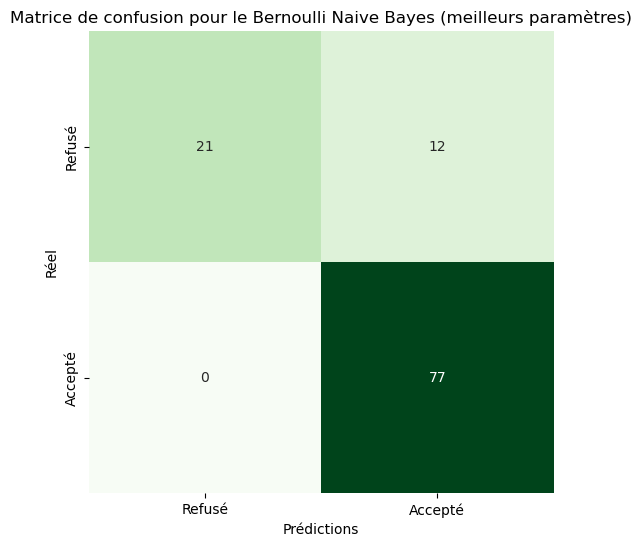

In [49]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
best_alpha = None
best_binarize = None
best_accuracy = 0
train_accuracies = []
val_accuracies = []

#Boucles pour tester différentes combinaisons d'hyperparamètres
for alpha in [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:  #On teste plusieurs valeurs pour alpha
    for binarize in [0.0, 0.5, 1.0, 2.0]:  #On teste plusieurs seuils de binarisation
        #Créer et entraîner le modèle
        bnb_model = BernoulliNB(alpha=alpha, binarize=binarize)
        bnb_model.fit(X_train, y_train)
        
        #Prédictions
        y_train_pred = bnb_model.predict(X_train)
        y_val_pred = bnb_model.predict(X_val)
        
        #Calcul des Accuracy
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        
        #Stocker les Accuracy et mettre à jour les meilleurs paramètres
        train_accuracies.append((alpha, binarize, train_acc))
        val_accuracies.append((alpha, binarize, val_acc))
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_alpha = alpha
            best_binarize = binarize

#Résultats finaux
print(f"Meilleurs hyperparamètres : alpha={best_alpha}, binarize={best_binarize}")
print(f"Meilleure accuracy (Validation): {best_accuracy:.2f}")

#Entraîner un modèle final avec les meilleurs hyperparamètres
best_bnb_model = BernoulliNB(alpha=best_alpha, binarize=best_binarize)
best_bnb_model.fit(X_train, y_train)

#Prédictions finales
y_pred_best = best_bnb_model.predict(X_val)

#Rapport de classification
accuracy_bnb_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_bnb_best:.2f}")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_bnb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_bnb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_bnb}")

#Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Refusé', 'Accepté'], yticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour le Bernoulli Naive Bayes (meilleurs paramètres)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

Avec une accuracy  de 89 %, le modèle Bernoulli Naives Bayes semble très bon.
La classe 1 est très bien prédite avec un recall parfait de 100 % et un bon f1-score de 93 % mais la classe 0 a l'air bonne avec un recall de 78 %. 
Modèle solide.

Le modèle de `Bernoulli Naives Bayes` a prédit :

- **21 Vrais négatifs** : Le modèle a correctement prédit que 21 prêts seraient refusés.

- **12 Faux positifs** : 12 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

## Gaussian Naive Bayes

Meilleur var_smoothing : 0.1
Meilleure accuracy (Validation) : 89.09%
Accuracy finale avec les meilleurs paramètres : 89.09%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.87      1.00      0.93        77

    accuracy                           0.89       110
   macro avg       0.93      0.82      0.85       110
weighted avg       0.91      0.89      0.88       110

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109]


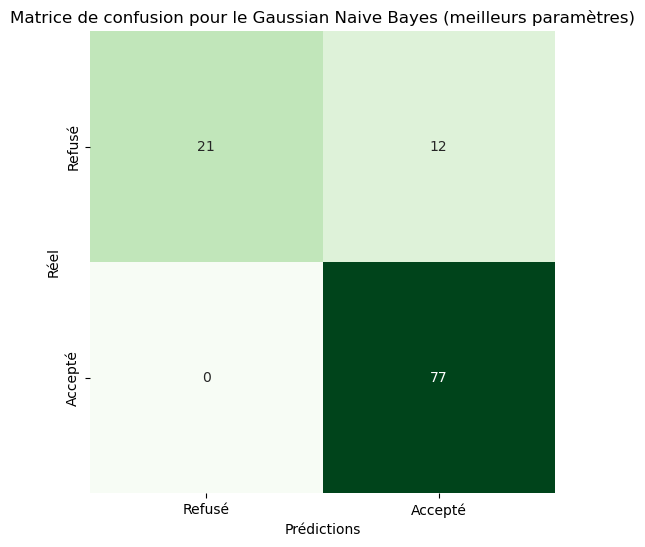

In [50]:
#On initialise des listes pour pouvoir comparer les différentes Accuracy qui seront enregistrées
best_var_smoothing = None
best_accuracy = 0
accuracy_list_train = []
accuracy_list_test = []

#Boucle sur différentes valeurs de var_smoothing
for i in range(1, 9):
    var_smoothing = 10**(-i)
    #Modèle Gaussian Naive Bayes
    gnb_model = GaussianNB(var_smoothing=var_smoothing)
    gnb_model.fit(X_train, y_train)

    #Prédictions
    y_pred_train = gnb_model.predict(X_train)
    y_pred_val = gnb_model.predict(X_val)

    #Accuracy sur entraînement et validation
    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)

    #Stocker les résultats
    accuracy_list_train.append(train_acc)
    accuracy_list_test.append(val_acc)

    #Mettre à jour les meilleurs paramètres si nécessaire
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_var_smoothing = var_smoothing

#Résultats des meilleurs paramètres
print(f"Meilleur var_smoothing : {best_var_smoothing}")
print(f"Meilleure accuracy (Validation) : {best_accuracy*100:.2f}%")

#Modèle final avec les meilleurs paramètres
best_gnb_model = GaussianNB(var_smoothing=best_var_smoothing)
best_gnb_model.fit(X_train, y_train)

#Prédictions finales
y_pred_best = best_gnb_model.predict(X_val)

#Rapport de classification
accuracy_gnb_best = accuracy_score(y_val, y_pred_best)
print(f"Accuracy finale avec les meilleurs paramètres : {accuracy_gnb_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best))

#Identifier les indices des Faux Positifs (FP)
fp_indices_gnb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_gnb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_gnb}")

#Matrice de confusion
conf_matrix_gnb = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gnb, annot=True, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Refusé', 'Accepté'], yticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour le Gaussian Naive Bayes (meilleurs paramètres)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

Avec une accuracy  de 89,09 %, le modèle Gaussian Naives Bayes semble très bien équilibré comme le Bernoulli Naives Bayes.
La classe 1 est parfaitement prédite avec un recall de 100 % et un bon f1-score de 93 % et posède un bon recall pour la classe 0 avec recall de 0,79.
Modèle solide.

Le modèle de `Gaussian Naives Bayes` a prédit :

- **21 Vrais négatifs** : Le modèle a correctement prédit que 21 prêts seraient refusés.

- **12 Faux positifs** : 12 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

# Gradiant Boost

Meilleurs paramètres : n_estimators=300, learning_rate=0.01, max_depth=5
Meilleure AUC-ROC : 0.86
Accuracy associée : 0.86

Rapport de classification avec les meilleurs hyperparamètres :

              precision    recall  f1-score   support

           0       0.91      0.61      0.73        33
           1       0.85      0.97      0.91        77

    accuracy                           0.86       110
   macro avg       0.88      0.79      0.82       110
weighted avg       0.87      0.86      0.85       110



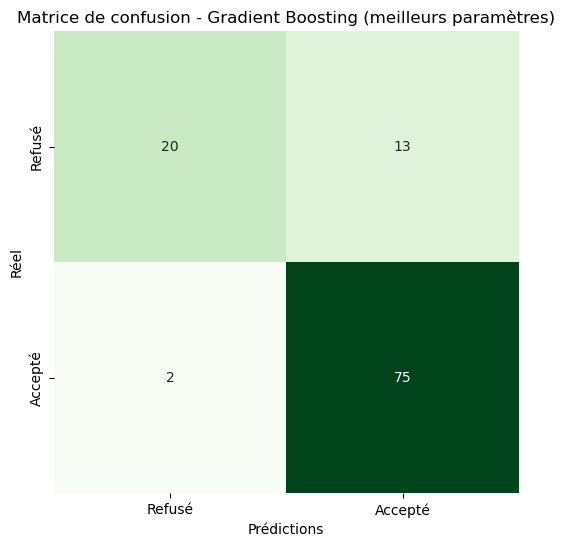

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 30, 34, 37, 53, 56, 65, 68, 74, 109]


In [51]:
#On initialise nos listes pour les hyperparamètres
best_params = None
best_accuracy = 0
best_roc_auc = 0
#Listes d'hyperparamètres à tester
n_estimators_list = [100, 300, 500]
learning_rate_list = [0.01, 0.05, 0.1]
max_depth_list = [3, 4, 5]
#Boucles pour trouver la meilleure combinaison d'hyperparamètres
for n_estimators in n_estimators_list:
    for learning_rate in learning_rate_list:
        for max_depth in max_depth_list:
            gbm_model = GradientBoostingClassifier(n_estimators=n_estimators,learning_rate=learning_rate,max_depth=max_depth,random_state=42)
            gbm_model.fit(X_train, y_train)
            y_pred_val = gbm_model.predict(X_val)
            y_pred_prob_val = gbm_model.predict_proba(X_val)[:, 1]
            accuracy_val = accuracy_score(y_val, y_pred_val)
            roc_auc_val = roc_auc_score(y_val, y_pred_prob_val)
            if roc_auc_val > best_roc_auc:
                best_roc_auc = roc_auc_val
                best_accuracy = accuracy_val
                best_params = (n_estimators, learning_rate, max_depth)
#On affiche les meilleurs paramètres et métriques
print(f"Meilleurs paramètres : n_estimators={best_params[0]}, learning_rate={best_params[1]}, max_depth={best_params[2]}")
print(f"Meilleure AUC-ROC : {best_roc_auc:.2f}")
print(f"Accuracy associée : {best_accuracy:.2f}")
#On entraine le modèle final avec les meilleurs paramètres
best_gbm_model = GradientBoostingClassifier(
    n_estimators=best_params[0],
    learning_rate=best_params[1],
    max_depth=best_params[2],
    random_state=42
)
best_gbm_model.fit(X_train, y_train)
#Prédictions finales
y_pred_best = best_gbm_model.predict(X_val)
y_pred_prob_best = best_gbm_model.predict_proba(X_val)[:, 1]
#Rapport de classification
print("\nRapport de classification avec les meilleurs hyperparamètres :\n")
print(classification_report(y_val, y_pred_best))
#Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Refusé', 'Accepté'], yticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion - Gradient Boosting (meilleurs paramètres)")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

# Identifier les faux positifs
fp_indices_gb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 0 and pred == 1]
fn_indices_gb = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_gb}")

Avec une accuracy  de 86 %, le modèle du Gradient Boost à une plutôt bonne Accuracy en règle générale.
La classe 1 est bien prédite avec un recall de 97 % et un bon f1-score de 91 % et possède un très bon recall pour la classe 0 avec recall de 0,91.

Le modèle de `Gradient Boost` a prédit :

- **20 Vrais négatifs** : Le modèle a correctement prédit que 20 prêts seraient refusés.

- **13 Faux positifs** : 13 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **2 Faux négatifs** : 2 prêts ont été refusés alors qu'ils auraient du être acceptés.

- **75 Vrais positifs** : Le modèle a correctement prédit que 75 prêts seraient acceptés.

Indices des Faux Négatifs (FN) : [26, 57]
Analyse des faux négatifs avec SHAP...


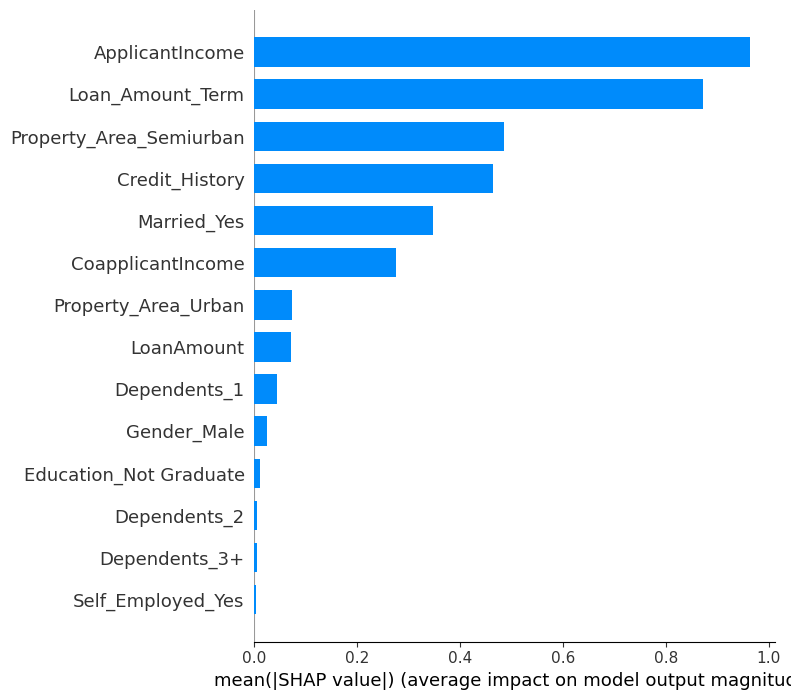

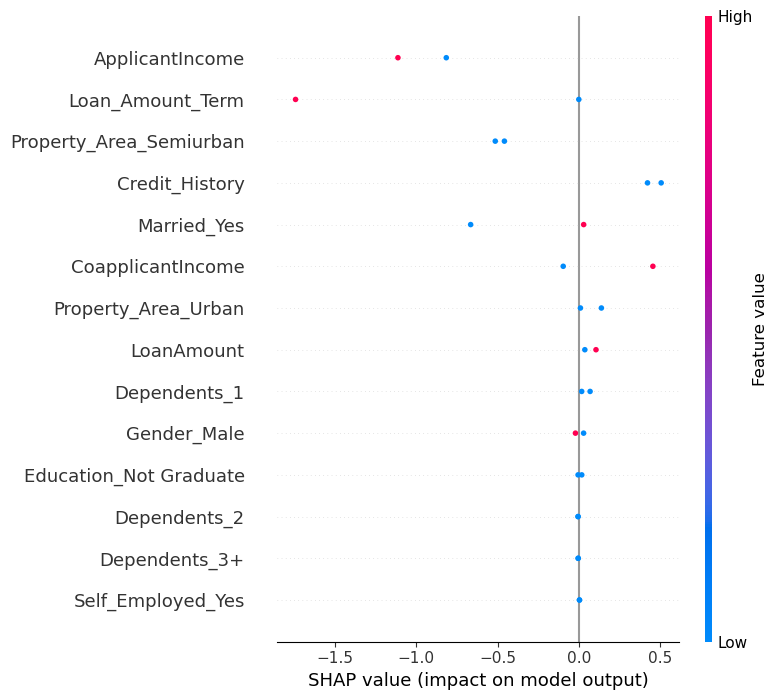

In [52]:
#Identifier les faux négatifs
fn_indices = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best)) if true == 1 and pred == 0]
print(f"Indices des Faux Négatifs (FN) : {fn_indices}")

#Préparer les données des faux négatifs pour l'explication
X_val_fn = X_val[fn_indices]
y_val_fn = y_val[fn_indices]

#SHAP pour les faux négatifs
print("Analyse des faux négatifs avec SHAP...")
explainer = shap.TreeExplainer(best_gbm_model)
shap_values_fn = explainer.shap_values(X_val_fn)
shap.summary_plot(shap_values_fn, X_val_fn, plot_type="bar", feature_names=X.columns)
shap.summary_plot(shap_values_fn, X_val_fn, feature_names=X.columns)
if len(fn_indices) > 0:
    example_index = 0
    shap.force_plot(
        explainer.expected_value,
        shap_values_fn[example_index, :],
        X_val_fn[example_index, :],
        feature_names=X.columns
    )

## Ai explainability :
Pour ce modèle de `Gradient Boost` ce qui joue le plus dans le choix d'acceptation du prêt est en premier les revenus du demandeur ce qui est logique, en second le temps que la personne prendra à le rembourser et enfin l'emplacement du logement de la personne (Zone Semi urbaine ou non)

# Catboost

Meilleurs paramètres CatBoost : iterations=200, learning_rate=0.01, depth=4
Meilleure accuracy (Validation) : 89.09%
Accuracy finale avec les meilleurs paramètres (CatBoost) : 89.09%

Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      0.64      0.78        33
           1       0.87      1.00      0.93        77

    accuracy                           0.89       110
   macro avg       0.93      0.82      0.85       110
weighted avg       0.91      0.89      0.88       110



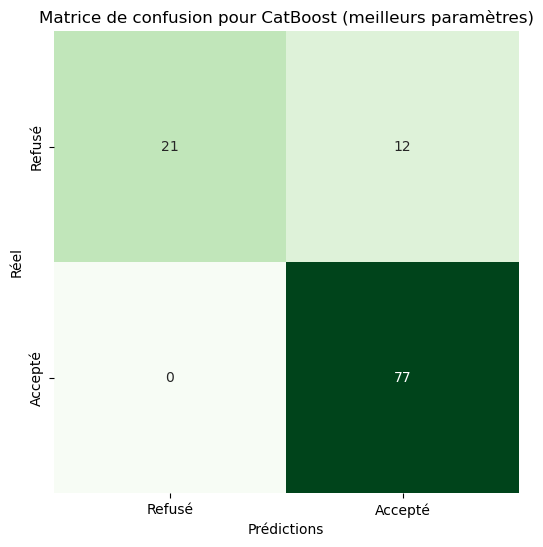

Indices des Faux Positifs (FP) : [2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109]


In [53]:
#Meilleurs paramètres trouvés
best_params_cat = None
best_accuracy_cat = 0
iterations_list = [200, 500, 1000]
learning_rate_list = [0.01, 0.1, 0.2]
depth_list = [4, 6, 8]

#Boucles pour tester les combinaisons d'hyperparamètres
for iterations in iterations_list:
    for learning_rate in learning_rate_list:
        for depth in depth_list:
            cat_model = CatBoostClassifier(
                iterations=iterations,
                learning_rate=learning_rate,
                depth=depth,
                random_state=42,
                verbose=0
            )
            cat_model.fit(X_train, y_train)
            y_pred_cat = cat_model.predict(X_val)
            accuracy_cat = accuracy_score(y_val, y_pred_cat)
            if accuracy_cat > best_accuracy_cat:
                best_accuracy_cat = accuracy_cat
                best_params_cat = (iterations, learning_rate, depth)

#Résultats des meilleurs paramètres
print(f"Meilleurs paramètres CatBoost : iterations={best_params_cat[0]}, learning_rate={best_params_cat[1]}, depth={best_params_cat[2]}")
print(f"Meilleure accuracy (Validation) : {best_accuracy_cat*100:.2f}%")

#Entraîner un modèle final avec les meilleurs paramètres
best_cat = CatBoostClassifier(
    iterations=best_params_cat[0],
    learning_rate=best_params_cat[1],
    depth=best_params_cat[2],
    random_state=42,
    verbose=0
)
best_cat.fit(X_train, y_train)

#Prédictions finales
y_pred_best_cat = best_cat.predict(X_val)

#Évaluation finale
accuracy_cat_best = accuracy_score(y_val, y_pred_best_cat)
print(f"Accuracy finale avec les meilleurs paramètres (CatBoost) : {accuracy_cat_best*100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_val, y_pred_best_cat))

#Matrice de confusion
conf_matrix_cat = confusion_matrix(y_val, y_pred_best_cat)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_cat, annot=True, fmt='g', cmap='Greens', cbar=False,
            xticklabels=['Refusé', 'Accepté'], yticklabels=['Refusé', 'Accepté'])
plt.title("Matrice de confusion pour CatBoost (meilleurs paramètres)")
plt.xlabel('Prédictions')
plt.ylabel('Réel')
plt.show()

#Analyse des faux positifs
fp_indices_cat = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best_cat)) if true == 0 and pred == 1]
fn_indices_cat = [i for i, (true, pred) in enumerate(zip(y_val, y_pred_best_cat)) if true == 1 and pred == 0]
print(f"Indices des Faux Positifs (FP) : {fp_indices_cat}")

Avec une accuracy  de 89,09 %, le modèle Cat Boost semble très bien équilibré comme le Bernoulli Naives Bayes.
La classe 1 est parfaitement prédite avec un recall de 100 % et un bon f1-score de 93 % et posède un bon recall pour la classe 0 avec recall de 0,79.
Modèle solide.

Le modèle de `Cat Boost` a prédit :

- **21 Vrais négatifs** : Le modèle a correctement prédit que 21 prêts seraient refusés.

- **12 Faux positifs** : 12 prêts ont été acceptés alors qu'ils auraient dû être refusés.

- **0 Faux négatifs** : Aucun prêt n'a été refusé alors qu'il aurait du être accepté.

- **77 Vrais positifs** : Le modèle a correctement prédit que 77 prêts seraient acceptés.

Analyse des faux positifs avec SHAP...


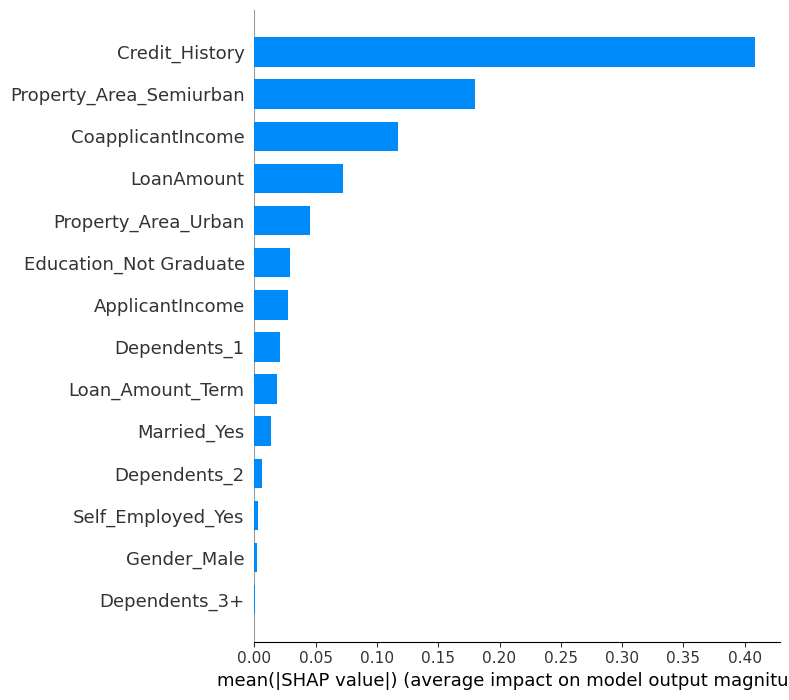

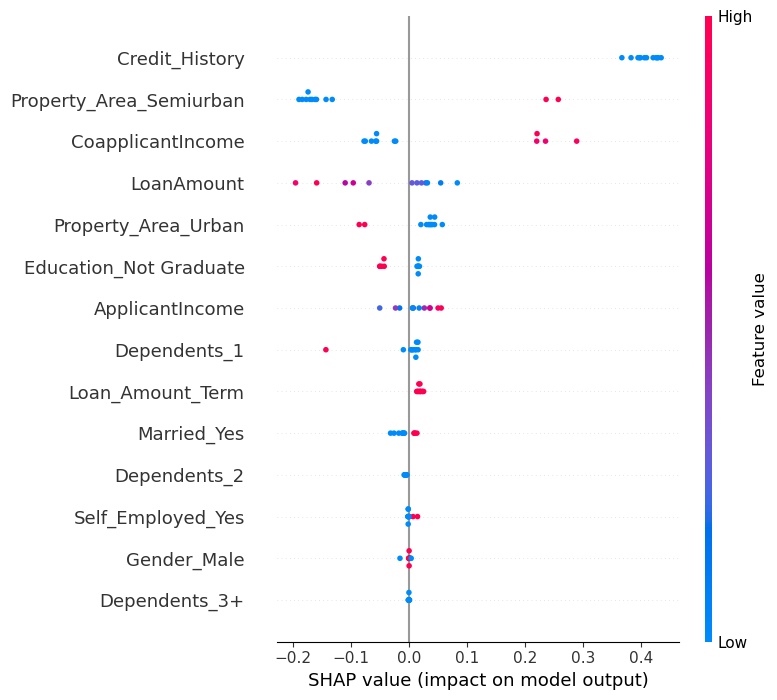

In [54]:
#On prépare les données pour expliquer les Faux positifs
X_val_fp = X_val[fp_indices_cat]
y_val_fp = y_val[fp_indices_cat]
#Shap pour les faux positifs
print("Analyse des faux positifs avec SHAP...")
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_val_fp)
shap.summary_plot(shap_values, X_val_fp, plot_type="bar", feature_names=X.columns)
shap.summary_plot(shap_values, X_val_fp, feature_names=X.columns)
#On analyse le 1er faux positif
if len(fp_indices_cat) > 0:
    example_index = 0
    shap.force_plot(
        explainer.expected_value,
        shap_values[example_index, :],
        X_val_fp[example_index, :],
        feature_names=X.columns
    )

## Ai explainability :
Pour le modèle de `Catboost` l'Historique de crédit vaut pratiquement 50% du choix d'acception du prêt, viens entuie l'emplacement du logement de la personne (Zone semi urbaine) et enfin les revenus du Codemandeur.

# Bilan sur les modèles :

**Les modèles commencent à être très performants ils ont l'air d'avoir très bien compris quand est ce qu'il faut refuser un prêt car ils ont à peu près tous une accuracy de 1 pour détecter la classe 0 (prêt refusé) mais la précision pour l'acceptation du prêt (classe 1) reste aux alentours de 0,88 ce qui reste très convenable mais il faut faire attention car si le modèle accepte des prêt qui aurait dû être refusé çapeut finir par coûter cher à une banque**

**Mais malgré tout le modèle à de très bon recall (1,00) pour détecter les prêts acceptés ce qui est très bon pour les clients il faut peser le pour et le contre mais les modèles ont de très bonnes capacités malgré les erreurs.**

# Comparaison et Interprétation

Pour évaluer l'impact financier des décisions automatisées de prêt par rapport aux décisions manuelles, il est essentiel de comprendre les implications et impacts des quatre catégories de prédiction : les vrais positifs, les vrais négatifs, les faux positifs et les faux négatifs.

- **`Vrais négatifs`** : La banque refuse un prêt alors qui aurait été refusé manuellement : Prédiction correct ➔ Aucune perte

- **`Faux négatifs`** : La banque refuse un prêt alors qu'il aurait été accepté manuellement : Mauvaise prédiction ➔ Perte car la banque peut manquer un client solvable.

- **`Faux positifs`** : La banque accepte un prêt alors qu'il aurait été refusé manuellement : Mauvaise prédiction ➔ Perte potentielle en cas de non remboursement.

- **`Vrais positifs`** : La banque accepte un prêt alors qu'il aurait été accepté manuellement : Prédiction correct ➔ Aucune perte

En somme, les `Faux positifs` sont généralement les moins rentables pour la banque : ils augmentent le risque de pertes financières dues à des prêts non remboursés. 

***Il est donc important de choisir un modèle bien calibré pour cette catégorie pour minimiser les occurrences de faux positifs et ainsi protéger les actifs de la banque.***

In [55]:
#On affiche le résumé des Accuracy de tous les modèles
models = ['Régression logistique', 'Régression linéaire', 'KNN', 'Arbre de décision', 
          'Random Forest', 'SVM', 'Bernoulli Naive Bayes', 'Gaussian Naive Bayes', 
          'Gradient Boosting', 'CatBoost']
accuracies = [accuracy_lr_best, accuracy_lin_val, accuracy_knn_best, accuracy_dt_best, 
              accuracy_rf_best, accuracy_svm_best, accuracy_bnb_best, accuracy_gnb_best, 
              best_accuracy, accuracy_cat_best]

for model, acc in zip(models, accuracies):
    print(f"Le modèle de {model} possède une Accuracy de : {acc:.2f}")

Le modèle de Régression logistique possède une Accuracy de : 0.89
Le modèle de Régression linéaire possède une Accuracy de : 0.90
Le modèle de KNN possède une Accuracy de : 0.86
Le modèle de Arbre de décision possède une Accuracy de : 0.90
Le modèle de Random Forest possède une Accuracy de : 0.90
Le modèle de SVM possède une Accuracy de : 0.89
Le modèle de Bernoulli Naive Bayes possède une Accuracy de : 0.89
Le modèle de Gaussian Naive Bayes possède une Accuracy de : 0.89
Le modèle de Gradient Boosting possède une Accuracy de : 0.86
Le modèle de CatBoost possède une Accuracy de : 0.89


Les modèles avec les meilleures Accuracys sont le **`Random Forest`**, la **`Régression linéaire`**, et l'**`Arbre de décision`**  en terme de précision, avec une Accuracy de 0,90 ce qui est remarquable par rapport au Stage 1

Tout les modèles ont une accuracy de 0,89 donc pratiquement 9 fois sur 10 ils prédisent bien si le prêt est accepté ou refusé

Tandis que les modèles de **`KNN`** et de **`Gradient Boost`** eux sont à 0,86 ce qui reste une bonne accuracy en soit. Mais ça m'étonne du Gradient Boost qui est censé être un des modèles les plus élaborées avec le CatBoost parmis tout ceux que j'ai mis, après je pense que le Gradient Boost montre surtout son efficacité avec de plus gros dataset, la petite taille de celui ci ne doit pas jouer en sa faveur.

Les accuracys ont vraiment bien progressés par rapport au Stage 2.

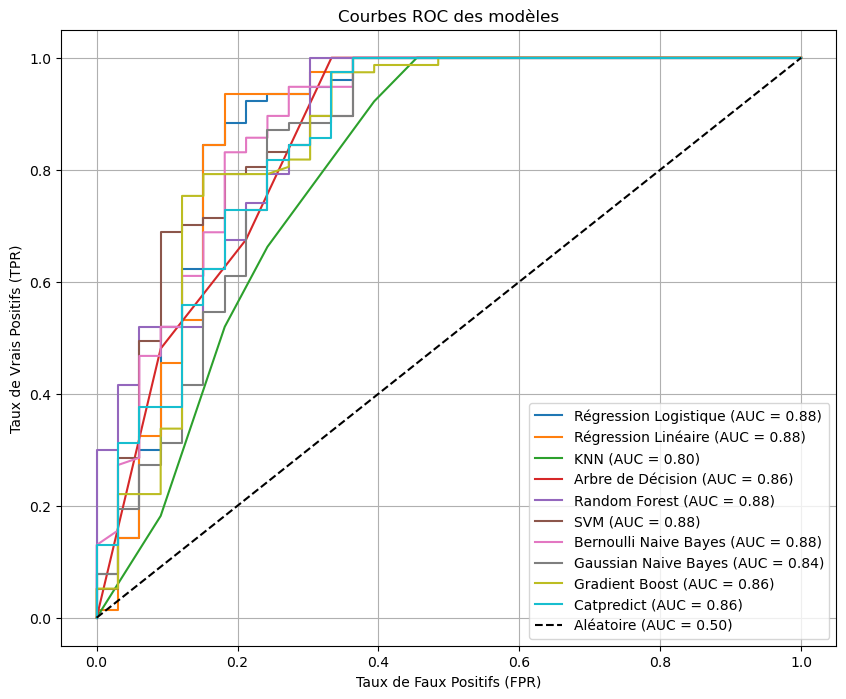

In [56]:
models = {
    "Régression Logistique": best_log_reg,
    "Régression Linéaire": lin_reg,
    "KNN": best_knn,
    "Arbre de Décision": best_dt,
    "Random Forest": best_rf,
    "SVM": best_svm,
    "Bernoulli Naive Bayes": best_bnb_model,
    "Gaussian Naive Bayes": best_gnb_model,
    "Gradient Boost": best_gbm_model,
    "Catpredict": best_cat,
}
plt.figure(figsize=(10, 8))
for name, model in models.items():
    #Probabilités pour la classe positive
    if name == "Régression Linéaire":
        y_proba = lin_reg.predict(X_val)  #Utiliser les prédictions continues
    elif hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    else:
        #Pour SVM et autres modèles qui n'ont pas `predict_proba`
        y_proba = model.decision_function(X_val) if hasattr(model, "decision_function") else model.predict(X_val)

    #Calcul ROC et AUC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)

    #Tracé de la courbe ROC
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

#Courbe aléatoire (diagonale)
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire (AUC = 0.50)')
plt.title('Courbes ROC des modèles')
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Interprétation
On remarque quand même que le modèle `Catboost` qui est censé être le plus technique et performant nous donne une des meilleurs Accuracy mais légèrement inférieur à certains modèles comme `Régression linéaire`, `Arbre de décision`... etc on peut en déduire une chose, c'est qu'on à réussi à effectuer un très bons traitements de données avec les Outliers, les Missing Value, la Normalisation/Standardisation car tout nos modèles obtiennent tous une Accuracy pratiquement similaire alors que certains sont des modèles simples (Regression lineaire/Logistique, KNN), certains utilisent des Arbres de décision (Décision Tree, Random Forest, Gradient Boost...) et certains modèles sont plus complexes et élaborés, le fait que le dataset soit petit ça ne fait pas trop varier nos résultats mais ce n'est pas tout, on peut dire que le traitement de données à été efficace.

In [57]:
# Dictionnaires pour stocker les indices des faux positifs (FP) et faux négatifs (FN) pour chaque modèle
fp_indices_dict = {}
fn_indices_dict = {}

# Collecter les indices des FP et FN pour chaque modèle
fp_indices_dict["Logistic Regression"] = fp_indices_log_reg
fn_indices_dict["Logistic Regression"] = fn_indices_log_reg

fp_indices_dict["Linear Regression"] = fp_indices_lin_reg
fn_indices_dict["Linear Regression"] = fn_indices_lin_reg

fp_indices_dict["KNN"] = fp_indices_knn
fn_indices_dict["KNN"] = fn_indices_knn

fp_indices_dict["Random Forest"] = fp_indices_rf
fn_indices_dict["Random Forest"] = fn_indices_rf

fp_indices_dict["Decision Tree"] = fp_indices_dt
fn_indices_dict["Decision Tree"] = fn_indices_dt

fp_indices_dict["SVM"] = fp_indices_svm
fn_indices_dict["SVM"] = fn_indices_svm

fp_indices_dict["Bernoulli Naive Bayes"] = fp_indices_bnb
fn_indices_dict["Bernoulli Naive Bayes"] = fn_indices_bnb

fp_indices_dict["Gaussian Naive Bayes"] = fp_indices_gnb
fn_indices_dict["Gaussian Naive Bayes"] = fn_indices_gnb

fp_indices_dict["Gradient Boost"] = fp_indices_gb
fn_indices_dict["Gradient Boost"] = fn_indices_gb

fp_indices_dict["Cat Boost"] = fp_indices_cat
fn_indices_dict["Cat Boost"] = fn_indices_cat

# Afficher les indices des Faux Positifs (FP) par modèle
print("Indices des Faux Positifs (FP) par modèle :")
for model_name, indices in fp_indices_dict.items():
    print(f"{indices} : {model_name}")

# Afficher les indices des Faux Négatifs (FN) par modèle
print("\nIndices des Faux Négatifs (FN) par modèle :")
for model_name, indices in fn_indices_dict.items():
    print(f"{indices} : {model_name} ")

Indices des Faux Positifs (FP) par modèle :
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109] : Logistic Regression
[9, 14, 17, 65, 68, 74] : Linear Regression
[2, 9, 14, 17, 34, 37, 53, 56, 63, 65, 68, 73, 74, 108, 109] : KNN
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 109] : Random Forest
[2, 9, 14, 34, 37, 53, 56, 65, 68, 74, 109] : Decision Tree
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109] : SVM
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109] : Bernoulli Naive Bayes
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109] : Gaussian Naive Bayes
[2, 9, 14, 17, 30, 34, 37, 53, 56, 65, 68, 74, 109] : Gradient Boost
[2, 9, 14, 17, 34, 37, 53, 56, 65, 68, 74, 109] : Cat Boost

Indices des Faux Négatifs (FN) par modèle :
[] : Logistic Regression 
[5, 59, 86, 95, 102] : Linear Regression 
[] : KNN 
[] : Random Forest 
[] : Decision Tree 
[] : SVM 
[] : Bernoulli Naive Bayes 
[] : Gaussian Naive Bayes 
[26, 57] : Gradient Boost 
[] : Cat Boost 


# Comparaison des FP et des FN selon les différents modèles
### FN :
On voit que tout les modèles ont une précision de 1 pour la classe 0 (Faux négatifs) à part le `Gradient Boost` et la `Régression Linéaire`

### FP :
- On remarque que les modèles qui ont 0,89 d'Accuracy ont exactement bloqués sur les mêmes faux positif
- Ceux qui ont 0,86 (`KNN` et `Gradient Boost`) eux ont de plus grandes listes, 2 de plus pour le `Gradient Boost` et 4 de plus pour le `KNN`
- Concernant ceux qui possèdent 0,90 d'Accuracy (`Random Forest`, `Régression Linéaire` et l'`Arbre de décision`), le `Random forest` et l'`Arbre de décision` ils ont la même liste alors que la `Régression linéaire` lui en a moins mais il en possède tout autant dans les FN

# Meilleurs modèles pour identifier FP et FN :
> Clairement on peut passer à la trappe le modèle de `Régression linéaire`, je préfère avoir un modèle qui est parfait dans une catégorie et fait ces erreurs dans l'autres qu'un modèle qui fait des erreurs dans les 2 côtés x) donc c'est entre **`Arbre de Décision`** et le **`Random Forest`**

- `Régression Logistique` : AUC = 0.88

Un des modèle les plus performants ici. La courbe montre une bonne capacité à discriminer entre les classes. La régression logistique est une solution robuste et bien adaptée aux données.

- `Régression linéaire` : AUC = 0.88

Un des modèle les plus performants ici. La courbe montre une bonne capacité à discriminer entre les classes. La régression logistique est une solution robuste et bien adaptée aux données.

- `KNN` : AUC = 0.80 

Performances correctes, mais bien moins bonnes que celle des autres.

- `Arbre de Décision` : AUC = 0.86

Performance bonne aux vus des autres modèles.

- `Random Forest` : AUC = 0.88

Comparable à la régression logistique.
La randomisation aide à améliorer la généralisation.

- `SVM` : AUC = 0.88

Le SVM est parmi les plus performants.

- `Benoulli Naive Bayes` : AUC = 0.88

Le modèle est un des plus performants ici, il montre une bonne capacité à pouvoir distinguer les classes.

- `Gaussian Naive Bayes` : AUC = 0.84

Le GNB est parmi les modèles les moins performants actuellement.

- `Gradient Boost` : AUC = 0.86

Performances correctes, mais moins bonnes que celles des meilleurs modèles.

- `CatBoost` : AUC = 0.86

Performances correctes, mais moins bonnes que celles des meilleurs modèles.


## **Le meilleur modèle est le `Random Forest`**

Avec une AUC de 0.88 et une Accuracy de 0,9 et avec la distrinction de FN et de FP, le modèle de Random Forest démontre qu'il est le modèle offrant le meilleur compromis entre précision et capacité à différencier les classes 0 et 1.

`Reg logistique, Bernoulli Naive Bayes et SVM` :

Les modèles de Regression logistique, Bernoulli Naive Bayes et SVM se classe en second avec une AUC de 0.88 et une Accuracy de 0,89, très proche du Random Forest. Ils restent tout de même des modèles très solides.

`Régression linéaire` :

Si on regardait seulement l'Accuracy et la courbe Roc-Auc, la Régression linéaire serait très viable après ça dépend du choix de l'utilisateur, s'il préfère avoir des Faux positifs et des Faux négatifs ou seulement des Faux positifs, peut-être qu'un autre l'aurait choisi comme meilleure modèle, personnellement je le classe plus loin.

`Arbre de Décision` :

Arbre de Décision avec une AUC respectives de 0,86 mais une Accuracy de 0,9, montrent des performances solide malgré une AUC plus faible que celle des autres.

`Cat Boost` :

Un bon modèle avec une Accuracy de 0,89 et un AUC de 0,86 aucun Faux négatif et le même nombres de Faux positifs que les meilleures modèles, ça reste un modèle très solide mais qui aurait pu être meilleure si sa courbe Roc-Auc ne rentrait pas en compte.

`Gaussian Naive Bayes` :

Un modèle normale par rapport aux autres avec Accuracy 0.89 mais un AUC de 0.84 comparabale au CatBoost bons modèles mais la courbe Roc joue trop dans la balance.

`Gradient Boost` :

Un des modèles les moints performants Accuracy 0.86,AUC 0.86 mais beaucoup plus de FN et de FP que les autres modèles.

`KNN` :

Le pire modèle ici avec une Accuracy de 0.86 et un AUC 0.80.

# Conclusion

Dans ce projet, nous avons abordé le défi de prédire l'approbation des prêts en utilisant des modèles de machine learning. Après avoir importé et préparé nos données, nous avons exploré plusieurs algorithmes de classification pour évaluer leur efficacité dans la prédiction de l'éligibilité aux prêts. Ces algorithmes incluaient la Régression Logistique, K-Nearest Neighbors, Arbres de Décision, Random Forest, Support Vector Machine, le Bernoulli Naive Bayes, le Gaussian Naive Bayes, le Gradient Boost et le Cat Boost.

Nos résultats ont démontré que le modèle de Random Forest a fourni les meilleures performances en termes de précision et d'autres métriques clés comme le score ROC-AUC et le taux de Faux positifs et Faux négatifs, ce qui indique une bonne capacité du modèle à distinguer entre les classes approuvées et non approuvées. L'importance de variables telles que les revenus, les antécédents de crédit, et d'autres facteurs démographiques ont été soulignées comme des prédicteurs significatifs de l'issue des demandes de prêt.